In [14]:
import tensorflow as tf
import numpy as np
from scipy.fft import dctn
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import clone_model
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from numpy.random import default_rng
from tensorflow.keras.models import load_model
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

In [15]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [16]:
train_images, test_images = train_images / 255.0, test_images / 255.0

In [17]:
train_images.shape

(50000, 32, 32, 3)

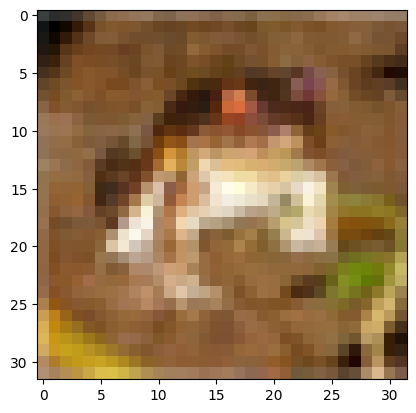

In [18]:
plt.imshow(train_images[0])

In [19]:
num_classes = 10
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

In [20]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

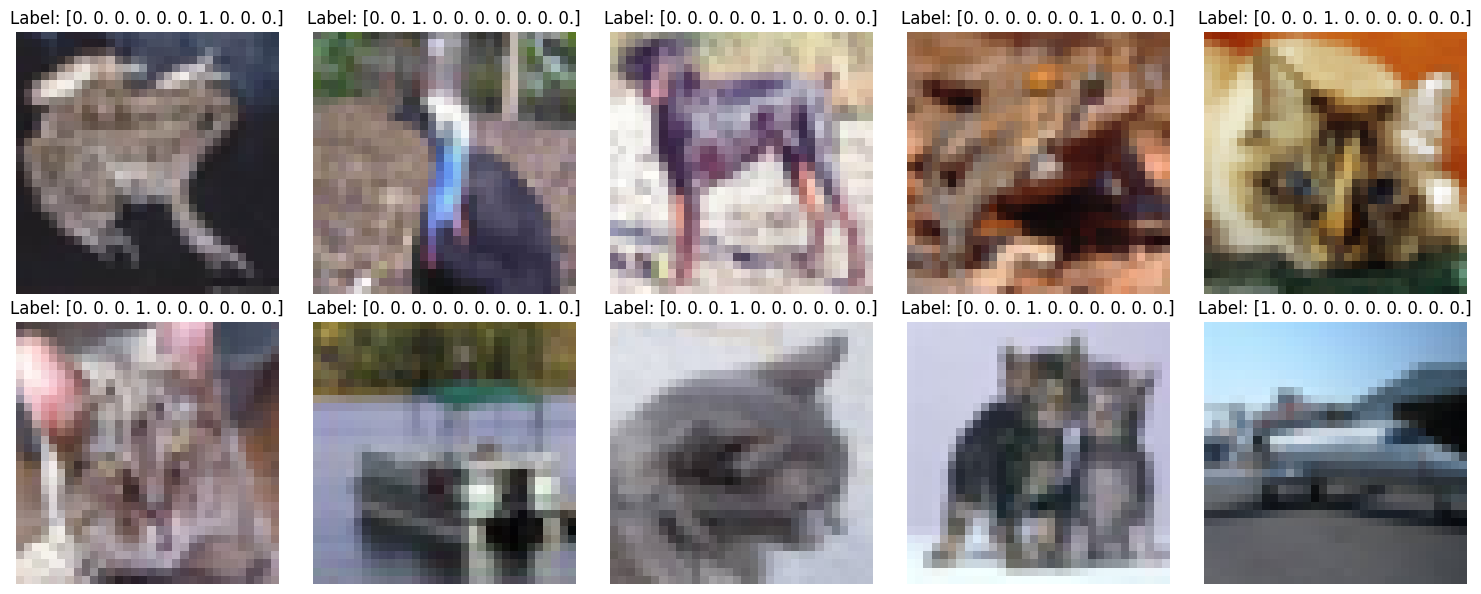

In [21]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for img, lbl, ax in zip(train_images, train_labels, axes):
    ax.imshow(img)
    ax.set_title(f'Label: {lbl}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [23]:
'''model_list = []

for i in range(10):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3), name='conv1'),
        MaxPooling2D((2,2), name='pool1'),
        Conv2D(64, (3,3), activation='relu', name='conv2'),
        MaxPooling2D((2,2), name='pool2'),
        Conv2D(64, (3,3), activation='relu', name='conv3'),
        Flatten(name='flatten'),
        Dense(64, activation='relu', name='fc1'),
        Dense(10, activation='softmax', name='output')
        ])
    model_list.append(model)'''
model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(64, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv3'),
        Conv2D(64, (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(128, (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv5'),
        Conv2D(128, (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(256, (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(128, activation='relu',kernel_initializer='he_normal', name='fc1'),
        Dense(64, activation='relu',kernel_initializer='he_normal', name='fc2'),
        Dense(10, activation='softmax', name='output')
        ])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv3 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 conv4 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 64)         

In [25]:
def get_flops(model, input_shape):
    # Create a concrete function from the Keras model
    @tf.function
    def model_func(x):
        return model(x)
    
    # Get the concrete function
    concrete_func = model_func.get_concrete_function(tf.TensorSpec(input_shape, model.inputs[0].dtype))
    
    # Convert variables to constants and get the frozen graph
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    frozen_graph = frozen_func.graph.as_graph_def()
    
    # Use TensorFlow's profiler
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(frozen_graph, name='')
        run_meta = tf.compat.v1.RunMetadata()
        with tf.compat.v1.Session(graph=graph) as sess:
            flops = tf.compat.v1.profiler.profile(
                graph=graph,
                run_meta=run_meta,
                cmd='op',
                options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
            )
            return flops.total_float_ops

In [27]:
'''for i in model_list:
    i.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    i.fit(X, y_one_hot, epochs=100, batch_size=2)
    loss_list.append(i.evaluate(X, y_one_hot)[0])
    accuracy_list.append(i.evaluate(X, y_one_hot)[1])'''
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_labels, epochs=50, batch_size=64, validation_data=(val_images, val_labels))

Epoch 1/50


2024-11-01 13:38:01.319244: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 6s 7ms/step - loss: 0.3756 - accuracy: 0.8702 - val_loss: 0.5555 - val_accuracy: 0.8199
Epoch 2/50
625/625 [==============================] - 4s 7ms/step - loss: 0.3656 - accuracy: 0.8724 - val_loss: 0.6003 - val_accuracy: 0.8107
Epoch 3/50
625/625 [==============================] - 5s 7ms/step - loss: 0.3616 - accuracy: 0.8731 - val_loss: 0.5950 - val_accuracy: 0.8032
Epoch 4/50
625/625 [==============================] - 5s 7ms/step - loss: 0.3521 - accuracy: 0.8794 - val_loss: 0.5654 - val_accuracy: 0.8152
Epoch 5/50
625/625 [==============================] - 4s 7ms/step - loss: 0.3485 - accuracy: 0.8786 - val_loss: 0.5785 - val_accuracy: 0.8135
Epoch 6/50
625/625 [==============================] - 4s 7ms/step - loss: 0.3485 - accuracy: 0.8789 - val_loss: 0.5604 - val_accuracy: 0.8239
Epoch 7/50
625/625 [==============================] - 4s 7ms/step - loss: 0.3413 - accuracy: 0.8814 - val_loss: 0.5723 - val_accuracy: 0.8206
Epoch 8/50
625/62

In [28]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)


313/313 - 1s - loss: 0.6215 - accuracy: 0.8263 - 709ms/epoch - 2ms/step


In [29]:
train_loss, train_acc = model.evaluate(train_images, train_labels, verbose=2)

1250/1250 - 2s - loss: 0.0867 - accuracy: 0.9794 - 2s/epoch - 1ms/step


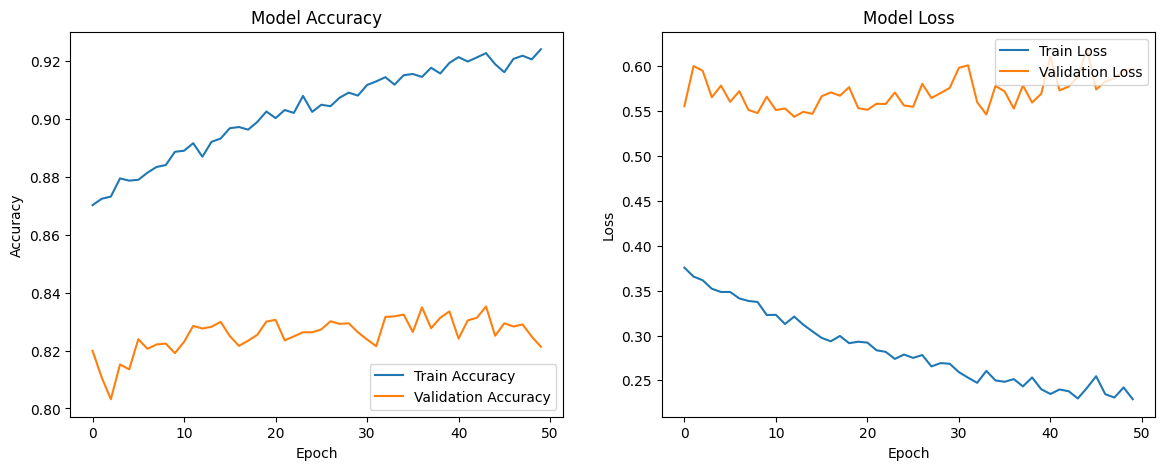

In [30]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()


In [31]:
model.save('model.h5')

/home/am/Documents/VirtualEnv/tensorflow-gpu/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
#for idx, model in enumerate(model_list):
#    model.save(f'model_{idx}.h5')
get_flops(model, train_images.shape)

2024-11-01 13:41:42.162040: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-01 13:41:42.162142: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-11-01 13:41:42.162221: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-11-01 13:41:42.162494: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-01 13:41:42.162599: I external/local_xla/xla/stream_executor/cuda/cuda_e

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation ker

2024-11-01 13:41:42.298124: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-01 13:41:42.298331: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-01 13:41:42.298421: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

3486576480000

              3468.17b float_ops (100.00%, 99.47%)
MatMul                   11.19b float_ops (0.53%, 0.32%)
BiasAdd                  4.76b float_ops (0.21%, 0.14%)
MaxPool                  2.46b float_ops (0.07%, 0.07%)
Softmax                  2.00m float_ops (0.00%, 0.00%)

======================End of Report==========================


In [33]:
def get_layer(model, layer_index):
    return [layer for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)][layer_index]

def get_filters(model, layer_index, filter_indices):
    layer = get_layer(model, layer_index)
    filters, biases = layer.get_weights()
    return filters[:, :, :, filter_indices]

def get_all_filters(model, layer_name):
    layer = model.get_layer(name=layer_name)
    filters, biases = layer.get_weights()
    return filters



In [34]:
get_all_filters(model, 'conv1').shape

(3, 3, 3, 32)

In [35]:
'''def norms(model_index, layer_index, model_list):    
    model_norm_list = []
    for model_idx, model in enumerate(model_list):
        #print(model_idx)
        layer_norm_list = []
        for layer_idx, layer in enumerate([layer for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]):
            #print(layer_idx)
            norm_list = []
            filters, biases = layer.get_weights()
            num_filters = filters.shape[-1]
            for i in range(num_filters):
                
                filt = filters[:, :, :, i]
                filt_matrix = filt.reshape(-1, filt.shape[-1])
                norm = np.linalg.norm(filt_matrix)
                norm_list.append(norm)
            layer_norm_list.append(norm_list)
        model_norm_list.append(layer_norm_list)
    return model_norm_list[model_index][layer_index]'''

'''def get_norm(model, layer_name):
    layer = model.get_layer(layer_name)
    filters, biases = layer.get_weights()
    num_filters = filters.shape[-1]
    norms = []
    for i in range(num_filters):
        filt = filters[:, :, :, i]
        filt_matrix = filt.reshape(-1, filt.shape[-1])
        norm = np.linalg.norm(filt_matrix)
        norms.append(norm)
    return norms

def get_filter_uniqueness(model, layer_name):
    layer = model.get_layer(layer_name)
    filters, biases = layer.get_weights()
    num_filters = filters.shape[-1]
    uniqueness_list = []
    for i in range(num_filters):
        filt = filters[:, :, :, i]
        filt_matrix = filt.reshape(-1, filt.shape[-1])
        uniqueness = np.linalg.norm(filt_matrix) - np.linalg.norm(get_all_filters(model, layer_name))

        uniqueness_list.append(uniqueness)
    return uniqueness_list

uniqueness_conv3 = get_filter_uniqueness(model, 'conv3')
uniqueness_conv4 = get_filter_uniqueness(model, 'conv4')
uniqueness_conv5 = get_filter_uniqueness(model, 'conv5')
uniqueness_conv6 = get_filter_uniqueness(model, 'conv6')
uniqueness_conv7 = get_filter_uniqueness(model, 'conv7')'''


def properties(model, layer_name, property_name):
    filter_norms = []
    filter_correlation = []
    feature_map_correlation = []
    feature_map_dct = []

    layer = model.get_layer(layer_name)
    filters, biases = layer.get_weights()
    num_filters = filters.shape[-1]

    if property_name == 'filter_norm':
        for i in range(num_filters):
            filt = filters[:, :, :, i]
            filt_matrix = filt.reshape(-1, filt.shape[-1])
            norm = np.linalg.norm(filt_matrix)
            filter_norms.append(norm)
        return filter_norms
    
    elif property_name == 'filter_correlation':
        for i in range(num_filters):
            filt = filters[:, :, :, i]
            filt_matrix = filt.reshape(-1, filt.shape[-1])
            uniqueness = np.linalg.norm(filt_matrix) - np.linalg.norm(get_all_filters(model, layer_name))
            filter_correlation.append(uniqueness)
        return filter_correlation
    
    elif property_name == 'feature_map_correlation':
        intermediate_model = models.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
        feature_maps = intermediate_model.predict(train_images[:1000])
        for i in range(num_filters):
            U, S, Vt = np.linalg.svd(feature_maps[:,:,:,i])
            #feature_map_correlation.append(np.sqrt(np.sum(np.abs(feature_maps))) - np.sqrt(np.sum(np.abs(feature_maps[:,:,:,i]))) )
            feature_map_correlation.append(np.sum(S > 1e-5))
        return feature_map_correlation
    
    elif property_name == 'feature_map_dct':
        intermediate_model = models.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
        feature_maps = intermediate_model.predict(train_images[:1000])
        for i in range(num_filters):
            feature_map_dct.append(np.sqrt(np.sum(np.abs(dctn(feature_maps, norm='ortho')))) - np.sqrt(np.sum(np.abs(dctn(feature_maps[:,:,:,i], norm='ortho')))) )
        return feature_map_dct


        


    


In [36]:
def filter_to_zero(norms, percentage):
    threshold = np.percentile(norms, percentage)
    return [i for i, norm in enumerate(norms) if norm < threshold]

def filter_to_keep(norms, percentage):
    threshold = np.percentile(norms, percentage)
    return [i for i, norm in enumerate(norms) if norm >= threshold]

# 70%

In [37]:
keep_filt_conv3_by_filt_norm = filter_to_keep(properties(model, 'conv3', 'filter_norm'), 70)
keep_filt_conv4_by_filt_norm = filter_to_keep(properties(model, 'conv4', 'filter_norm'), 70)
keep_filt_conv5_by_filt_norm = filter_to_keep(properties(model, 'conv5', 'filter_norm'), 90)
keep_filt_conv6_by_filt_norm = filter_to_keep(properties(model, 'conv6', 'filter_norm'), 90)
keep_filt_conv7_by_filt_norm = filter_to_keep(properties(model, 'conv7', 'filter_norm'), 90)



In [38]:
'''pruned_target_model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=X.shape[1:], name='target_conv1'),
        MaxPooling2D((2,2), name='target_pool1'),
        Conv2D(len(keep_filt), (3,3), activation='relu', name='target_conv2'),
        MaxPooling2D((2,2), name='target_pool2'),
        Flatten(name='target_flatten'),
        Dense(len(keep_filt), activation='relu', name='target_fc1'),
        Dense(10, activation='softmax', name='target_output')
        ])'''

pruned_target_model_by_filt_norm = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv3_by_filt_norm), (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv3'),
        Conv2D(len(keep_filt_conv4_by_filt_norm), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv5_by_filt_norm), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv5'),
        Conv2D(len(keep_filt_conv6_by_filt_norm), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv7_by_filt_norm), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(len(keep_filt_conv7_by_filt_norm), activation='relu',kernel_initializer='he_normal', name='fc1'),
        Dense(64, activation='relu',kernel_initializer='he_normal', name='fc2'),
        Dense(10, activation='softmax', name='output')
        ])

In [39]:
pruned_target_model_by_filt_norm.summary()
get_flops(pruned_target_model_by_filt_norm, train_images.shape)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 dropout_8 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv3 (Conv2D)              (None, 16, 16, 19)        5491      
                                                                 
 conv4 (Conv2D)              (None, 16, 16, 19)        3268      
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 19)         

2024-11-01 13:41:42.509113: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-01 13:41:42.509208: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-11-01 13:41:42.509282: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-11-01 13:41:42.509479: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-01 13:41:42.509591: I external/local_xla/xla/stream_executor/cuda/cuda_e

1032478320000

In [40]:
'''def copy_weights_pruned(source_model, pruned_target_model, source_layer_name, target_layer_name):
    for source_layer, target_layer in zip(source_model.layers, pruned_target_model.layers):
        if isinstance(source_layer, tf.keras.layers.Conv2D) and source_layer.name != source_layer_name and target_layer.name != target_layer_name:
            w, b = source_layer.get_weights()
            target_layer.set_weights([w, b])
        elif source_layer.name == source_layer_name and target_layer.name == target_layer_name:
            w, b = source_layer.get_weights()
            target_layer.set_weights([w[:, :, :, keep_filt], b[keep_filt]])'''
def get_var_name(var):
    for name, value in locals().items():
        if value is var:
            return name

def copy_weights_pruned(source_model, pruned_target_model, source_layer_names, target_layer_names, keep_filters):
    for source_layer, target_layer in zip(source_model.layers, pruned_target_model.layers):
        if isinstance(source_layer, tf.keras.layers.Conv2D) and source_layer.name not in source_layer_names and target_layer.name not in target_layer_names:
            w, b = source_layer.get_weights()
            target_layer.set_weights([w, b])
        elif source_layer.name in source_layer_names and target_layer.name in target_layer_names:
            for keep_filt in keep_filters:
                if source_layer.name in get_var_name(keep_filt):
                    w, b = source_layer.get_weights()
                    target_layer.set_weights([w[:, :, :, keep_filt], b[keep_filt]])
               
        

In [41]:
copy_weights_pruned(model, pruned_target_model_by_filt_norm, [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ keep_filt_conv3_by_filt_norm, keep_filt_conv4_by_filt_norm, keep_filt_conv5_by_filt_norm, keep_filt_conv6_by_filt_norm, keep_filt_conv7_by_filt_norm])

In [42]:
pruned_target_model_by_filt_norm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = pruned_target_model_by_filt_norm.fit(train_images, train_labels, epochs=50, batch_size=64, validation_data=(val_images, val_labels))

Epoch 1/50


2024-11-01 13:41:43.744773: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 6s 6ms/step - loss: 1.8933 - accuracy: 0.2652 - val_loss: 1.5644 - val_accuracy: 0.4225
Epoch 2/50
625/625 [==============================] - 3s 5ms/step - loss: 1.4773 - accuracy: 0.4440 - val_loss: 1.2631 - val_accuracy: 0.5397
Epoch 3/50
625/625 [==============================] - 4s 6ms/step - loss: 1.3098 - accuracy: 0.5165 - val_loss: 1.1756 - val_accuracy: 0.5693
Epoch 4/50
625/625 [==============================] - 3s 5ms/step - loss: 1.2062 - accuracy: 0.5618 - val_loss: 1.0770 - val_accuracy: 0.6122
Epoch 5/50
625/625 [==============================] - 4s 6ms/step - loss: 1.1513 - accuracy: 0.5803 - val_loss: 1.0750 - val_accuracy: 0.6137
Epoch 6/50
625/625 [==============================] - 3s 5ms/step - loss: 1.1057 - accuracy: 0.6004 - val_loss: 1.0172 - val_accuracy: 0.6355
Epoch 7/50
625/625 [==============================] - 4s 6ms/step - loss: 1.0671 - accuracy: 0.6122 - val_loss: 0.9505 - val_accuracy: 0.6612
Epoch 8/50
625/62

In [43]:
test_loss, test_acc = pruned_target_model_by_filt_norm.evaluate(test_images, test_labels, verbose=2)


313/313 - 0s - loss: 0.7937 - accuracy: 0.7270 - 491ms/epoch - 2ms/step


In [44]:
train_loss, train_acc = pruned_target_model_by_filt_norm.evaluate(train_images, train_labels, verbose=2)


1250/1250 - 1s - loss: 0.6851 - accuracy: 0.7661 - 1s/epoch - 1ms/step


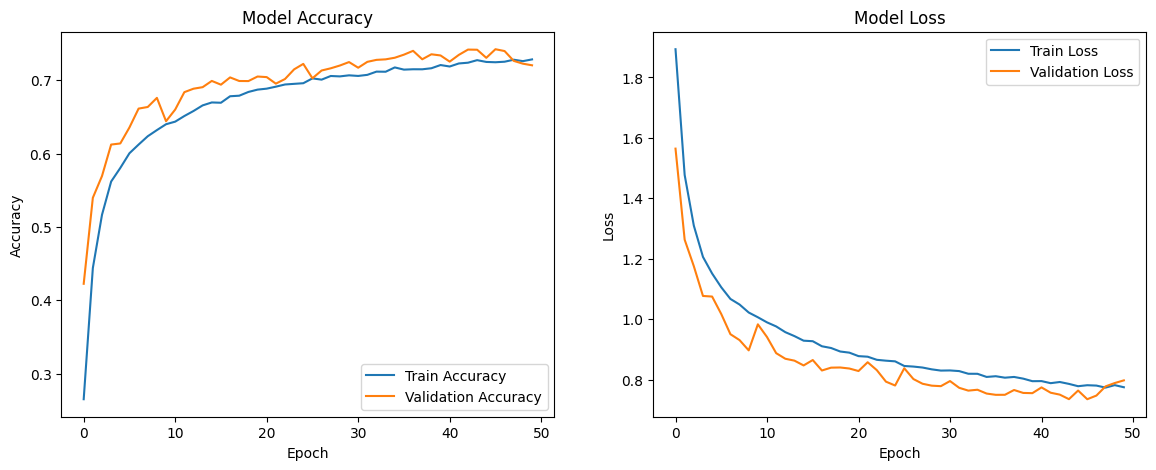

In [45]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()


In [46]:
pruned_target_model_by_filt_norm.save('pruned_target_by_filt_norm_flop70.h5')

In [47]:
keep_filt_conv3_by_filt_correlation = filter_to_keep(properties(model, 'conv3', 'filter_correlation'), 70)
keep_filt_conv4_by_filt_correlation = filter_to_keep(properties(model, 'conv4', 'filter_correlation'), 70)
keep_filt_conv5_by_filt_correlation = filter_to_keep(properties(model, 'conv5', 'filter_correlation'), 90)
keep_filt_conv6_by_filt_correlation = filter_to_keep(properties(model, 'conv6', 'filter_correlation'), 90)
keep_filt_conv7_by_filt_correlation = filter_to_keep(properties(model, 'conv7', 'filter_correlation'), 90)


In [48]:
pruned_target_model_by_filt_correlation = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv3_by_filt_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv3'),
        Conv2D(len(keep_filt_conv4_by_filt_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv5_by_filt_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv5'),
        Conv2D(len(keep_filt_conv6_by_filt_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv7_by_filt_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(len(keep_filt_conv7_by_filt_correlation), activation='relu',kernel_initializer='he_normal', name='fc1'),
        Dense(64, activation='relu',kernel_initializer='he_normal', name='fc2'),
        Dense(10, activation='softmax', name='output')
        ])

In [49]:
copy_weights_pruned(model, pruned_target_model_by_filt_correlation, [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ keep_filt_conv3_by_filt_correlation, keep_filt_conv4_by_filt_correlation, keep_filt_conv5_by_filt_correlation, keep_filt_conv6_by_filt_correlation, keep_filt_conv7_by_filt_correlation])

In [50]:
pruned_target_model_by_filt_correlation.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = pruned_target_model_by_filt_correlation.fit(train_images, train_labels, epochs=50, batch_size=64, validation_data=(val_images, val_labels))

Epoch 1/50


2024-11-01 13:44:24.395783: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 6s 7ms/step - loss: 1.9325 - accuracy: 0.2364 - val_loss: 1.6610 - val_accuracy: 0.3543
Epoch 2/50
625/625 [==============================] - 4s 6ms/step - loss: 1.5199 - accuracy: 0.4238 - val_loss: 1.3104 - val_accuracy: 0.5079
Epoch 3/50
625/625 [==============================] - 3s 5ms/step - loss: 1.3301 - accuracy: 0.4987 - val_loss: 1.2040 - val_accuracy: 0.5575
Epoch 4/50
625/625 [==============================] - 3s 5ms/step - loss: 1.2291 - accuracy: 0.5468 - val_loss: 1.0685 - val_accuracy: 0.6184
Epoch 5/50
625/625 [==============================] - 3s 5ms/step - loss: 1.1553 - accuracy: 0.5813 - val_loss: 1.0384 - val_accuracy: 0.6249
Epoch 6/50
625/625 [==============================] - 3s 4ms/step - loss: 1.1014 - accuracy: 0.5997 - val_loss: 0.9872 - val_accuracy: 0.6429
Epoch 7/50
625/625 [==============================] - 3s 5ms/step - loss: 1.0657 - accuracy: 0.6179 - val_loss: 0.9524 - val_accuracy: 0.6593
Epoch 8/50
625/62

In [51]:
test_loss, test_acc = pruned_target_model_by_filt_correlation.evaluate(test_images, test_labels, verbose=2)


313/313 - 0s - loss: 0.7719 - accuracy: 0.7270 - 364ms/epoch - 1ms/step


In [52]:
train_loss, train_acc = pruned_target_model_by_filt_correlation.evaluate(train_images, train_labels, verbose=2)


1250/1250 - 1s - loss: 0.6534 - accuracy: 0.7745 - 1s/epoch - 1ms/step


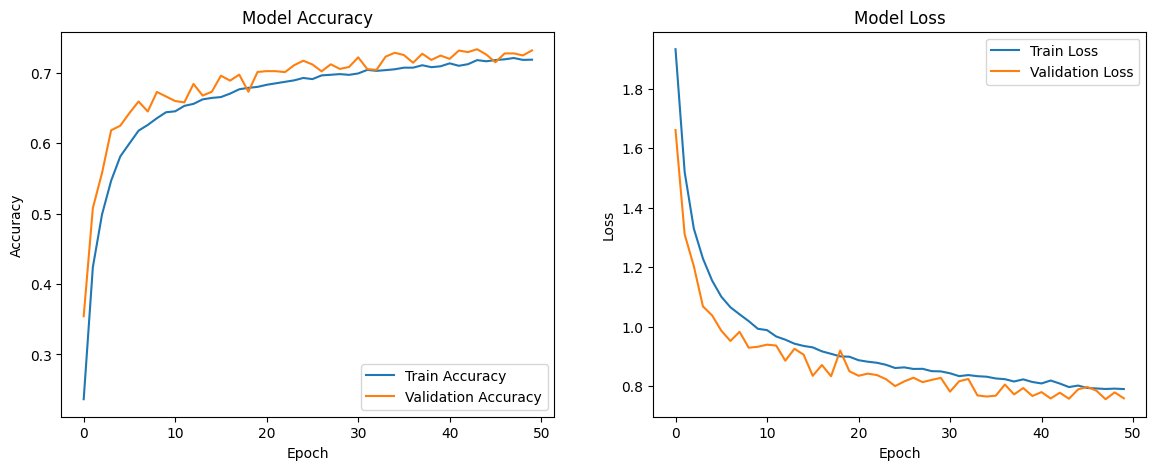

In [53]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

In [54]:
pruned_target_model_by_filt_correlation.save('pruned_target_by_filt_correlation_flop70.h5')

In [55]:
keep_filt_conv3_by_feature_map_correlation = filter_to_keep(properties(model, 'conv3', 'feature_map_correlation'), 70)
keep_filt_conv4_by_feature_map_correlation = filter_to_keep(properties(model, 'conv4', 'feature_map_correlation'), 70)
keep_filt_conv5_by_feature_map_correlation = filter_to_keep(properties(model, 'conv5', 'feature_map_correlation'), 90)
keep_filt_conv6_by_feature_map_correlation = filter_to_keep(properties(model, 'conv6', 'feature_map_correlation'), 90)
keep_filt_conv7_by_feature_map_correlation = filter_to_keep(properties(model, 'conv7', 'feature_map_correlation'), 90)

32/32 [==============================] - 0s 4ms/step


In [56]:
pruned_target_model_by_feature_map_correlation = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv3_by_feature_map_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv3'),
        Conv2D(len(keep_filt_conv4_by_feature_map_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv5_by_feature_map_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv5'),
        Conv2D(len(keep_filt_conv6_by_feature_map_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv7_by_feature_map_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(len(keep_filt_conv7_by_feature_map_correlation), activation='relu',kernel_initializer='he_normal', name='fc1'),
        Dense(64, activation='relu',kernel_initializer='he_normal', name='fc2'),
        Dense(10, activation='softmax', name='output')
        ])

In [57]:
copy_weights_pruned(model, pruned_target_model_by_feature_map_correlation, [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ keep_filt_conv3_by_feature_map_correlation, keep_filt_conv4_by_feature_map_correlation, keep_filt_conv5_by_feature_map_correlation, keep_filt_conv6_by_feature_map_correlation, keep_filt_conv7_by_feature_map_correlation])

In [58]:
pruned_target_model_by_feature_map_correlation.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = pruned_target_model_by_feature_map_correlation.fit(train_images, train_labels, epochs=50, batch_size=64, validation_data=(val_images, val_labels))

Epoch 1/50


2024-11-01 13:47:11.369013: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 5s 5ms/step - loss: 1.8525 - accuracy: 0.2731 - val_loss: 1.5258 - val_accuracy: 0.4287
Epoch 2/50
625/625 [==============================] - 3s 4ms/step - loss: 1.4740 - accuracy: 0.4411 - val_loss: 1.3368 - val_accuracy: 0.4898
Epoch 3/50
625/625 [==============================] - 3s 4ms/step - loss: 1.3398 - accuracy: 0.5012 - val_loss: 1.1923 - val_accuracy: 0.5670
Epoch 4/50
625/625 [==============================] - 3s 4ms/step - loss: 1.2488 - accuracy: 0.5414 - val_loss: 1.1098 - val_accuracy: 0.6005
Epoch 5/50
625/625 [==============================] - 3s 5ms/step - loss: 1.1814 - accuracy: 0.5715 - val_loss: 1.0567 - val_accuracy: 0.6181
Epoch 6/50
625/625 [==============================] - 3s 5ms/step - loss: 1.1391 - accuracy: 0.5861 - val_loss: 1.0255 - val_accuracy: 0.6288
Epoch 7/50
625/625 [==============================] - 3s 5ms/step - loss: 1.0926 - accuracy: 0.6045 - val_loss: 1.0143 - val_accuracy: 0.6420
Epoch 8/50
625/62

In [59]:
test_loss, test_acc = pruned_target_model_by_feature_map_correlation.evaluate(test_images, test_labels, verbose=2)


313/313 - 0s - loss: 0.7696 - accuracy: 0.7255 - 376ms/epoch - 1ms/step


In [60]:
train_loss, train_acc = pruned_target_model_by_feature_map_correlation.evaluate(train_images, train_labels, verbose=2)


1250/1250 - 2s - loss: 0.6547 - accuracy: 0.7697 - 2s/epoch - 1ms/step


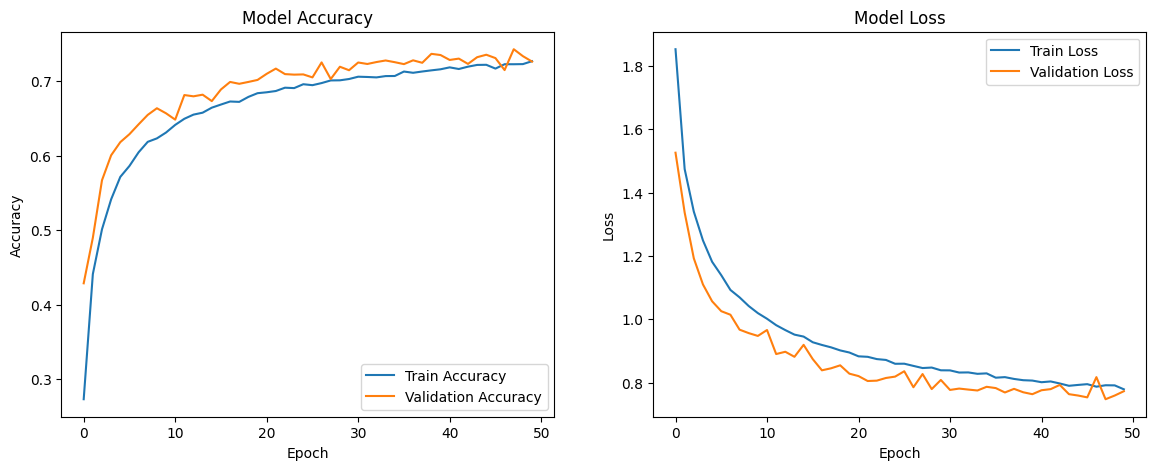

In [61]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

In [62]:
pruned_target_model_by_feature_map_correlation.save('pruned_target_by_feature_map_correlation_flop70.h5')

In [63]:
keep_filt_conv3_by_feature_map_dct = filter_to_keep(properties(model, 'conv3', 'feature_map_dct'), 70)
keep_filt_conv4_by_feature_map_dct = filter_to_keep(properties(model, 'conv4', 'feature_map_dct'), 70)
keep_filt_conv5_by_feature_map_dct = filter_to_keep(properties(model, 'conv5', 'feature_map_dct'), 90)
keep_filt_conv6_by_feature_map_dct = filter_to_keep(properties(model, 'conv6', 'feature_map_dct'), 90)
keep_filt_conv7_by_feature_map_dct = filter_to_keep(properties(model, 'conv7', 'feature_map_dct'), 90)

32/32 [==============================] - 0s 858us/step


In [64]:
pruned_target_model_by_feature_map_dct = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv3_by_feature_map_dct), (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv3'),
        Conv2D(len(keep_filt_conv4_by_feature_map_dct), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv5_by_feature_map_dct), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv5'),
        Conv2D(len(keep_filt_conv6_by_feature_map_dct), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv7_by_feature_map_dct), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(len(keep_filt_conv7_by_feature_map_dct), activation='relu',kernel_initializer='he_normal', name='fc1'),
        Dense(64, activation='relu',kernel_initializer='he_normal', name='fc2'),
        Dense(10, activation='softmax', name='output')
        ])

In [65]:
copy_weights_pruned(model, pruned_target_model_by_feature_map_dct, [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ keep_filt_conv3_by_feature_map_dct, keep_filt_conv4_by_feature_map_dct, keep_filt_conv5_by_feature_map_dct, keep_filt_conv6_by_feature_map_dct, keep_filt_conv7_by_feature_map_dct])

In [66]:
pruned_target_model_by_feature_map_dct.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = pruned_target_model_by_feature_map_dct.fit(train_images, train_labels, epochs=50, batch_size=64, validation_data=(val_images, val_labels))

Epoch 1/50


2024-11-01 13:50:47.907381: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 5s 6ms/step - loss: 1.8867 - accuracy: 0.2640 - val_loss: 1.5144 - val_accuracy: 0.4144
Epoch 2/50
625/625 [==============================] - 3s 5ms/step - loss: 1.4739 - accuracy: 0.4310 - val_loss: 1.3851 - val_accuracy: 0.4610
Epoch 3/50
625/625 [==============================] - 4s 6ms/step - loss: 1.3204 - accuracy: 0.5093 - val_loss: 1.1957 - val_accuracy: 0.5702
Epoch 4/50
625/625 [==============================] - 4s 6ms/step - loss: 1.2256 - accuracy: 0.5531 - val_loss: 1.0789 - val_accuracy: 0.6078
Epoch 5/50
625/625 [==============================] - 3s 5ms/step - loss: 1.1528 - accuracy: 0.5831 - val_loss: 1.0037 - val_accuracy: 0.6406
Epoch 6/50
625/625 [==============================] - 3s 5ms/step - loss: 1.1129 - accuracy: 0.5944 - val_loss: 1.0204 - val_accuracy: 0.6297
Epoch 7/50
625/625 [==============================] - 3s 5ms/step - loss: 1.0872 - accuracy: 0.6047 - val_loss: 0.9939 - val_accuracy: 0.6444
Epoch 8/50
625/62

In [67]:
test_loss, test_acc = pruned_target_model_by_feature_map_dct.evaluate(test_images, test_labels, verbose=2)


313/313 - 0s - loss: 0.7411 - accuracy: 0.7377 - 373ms/epoch - 1ms/step


In [68]:
train_loss, train_acc = pruned_target_model_by_feature_map_dct.evaluate(train_images, train_labels, verbose=2)


1250/1250 - 2s - loss: 0.6144 - accuracy: 0.7818 - 2s/epoch - 1ms/step


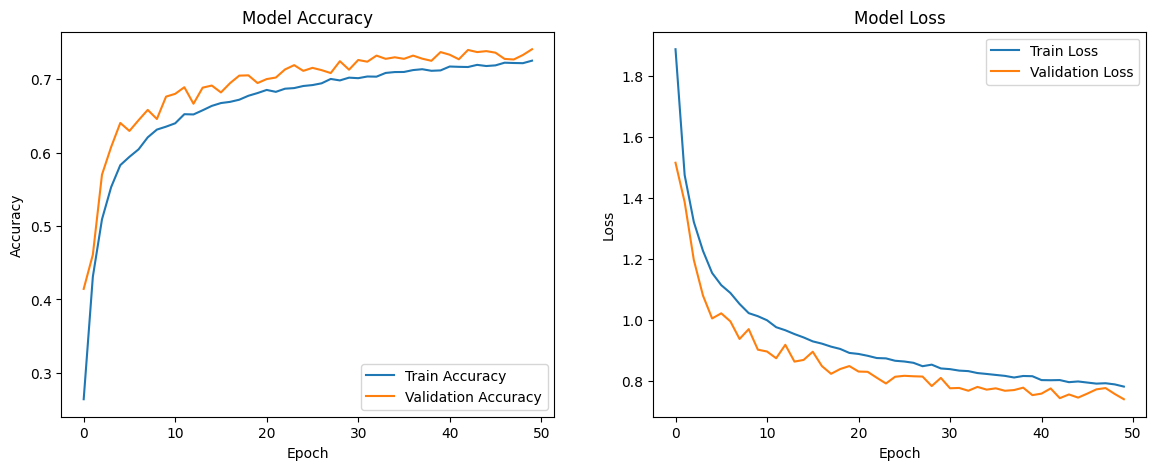

In [69]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

In [70]:
pruned_target_model_by_feature_map_dct.save('pruned_target_by_feature_map_dct_flop70.h5')

# 60%

In [71]:
keep_filt_conv3_by_filt_norm = filter_to_keep(properties(model, 'conv3', 'filter_norm'), 50)
keep_filt_conv4_by_filt_norm = filter_to_keep(properties(model, 'conv4', 'filter_norm'), 50)
keep_filt_conv5_by_filt_norm = filter_to_keep(properties(model, 'conv5', 'filter_norm'), 70)
keep_filt_conv6_by_filt_norm = filter_to_keep(properties(model, 'conv6', 'filter_norm'), 70)
keep_filt_conv7_by_filt_norm = filter_to_keep(properties(model, 'conv7', 'filter_norm'), 60)



In [72]:
'''pruned_target_model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=X.shape[1:], name='target_conv1'),
        MaxPooling2D((2,2), name='target_pool1'),
        Conv2D(len(keep_filt), (3,3), activation='relu', name='target_conv2'),
        MaxPooling2D((2,2), name='target_pool2'),
        Flatten(name='target_flatten'),
        Dense(len(keep_filt), activation='relu', name='target_fc1'),
        Dense(10, activation='softmax', name='target_output')
        ])'''

pruned_target_model_by_filt_norm = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv3_by_filt_norm), (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv3'),
        Conv2D(len(keep_filt_conv4_by_filt_norm), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv5_by_filt_norm), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv5'),
        Conv2D(len(keep_filt_conv6_by_filt_norm), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv7_by_filt_norm), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(len(keep_filt_conv7_by_filt_norm), activation='relu',kernel_initializer='he_normal', name='fc1'),
        Dense(64, activation='relu',kernel_initializer='he_normal', name='fc2'),
        Dense(10, activation='softmax', name='output')
        ])

In [73]:
pruned_target_model_by_filt_norm.summary()
get_flops(pruned_target_model_by_filt_norm, train_images.shape)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 dropout_24 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv3 (Conv2D)              (None, 16, 16, 32)        9248      
                                                                 
 conv4 (Conv2D)              (None, 16, 16, 32)        9248      
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 32)         

2024-11-01 13:53:47.516563: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-01 13:53:47.516666: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-11-01 13:53:47.516729: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-11-01 13:53:47.516924: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-01 13:53:47.517134: I external/local_xla/xla/stream_executor/cuda/cuda_e

1386441400000

-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profile:
node name | # float_ops
Conv2D     

In [77]:
'''def copy_weights_pruned(source_model, pruned_target_model, source_layer_name, target_layer_name):
    for source_layer, target_layer in zip(source_model.layers, pruned_target_model.layers):
        if isinstance(source_layer, tf.keras.layers.Conv2D) and source_layer.name != source_layer_name and target_layer.name != target_layer_name:
            w, b = source_layer.get_weights()
            target_layer.set_weights([w, b])
        elif source_layer.name == source_layer_name and target_layer.name == target_layer_name:
            w, b = source_layer.get_weights()
            target_layer.set_weights([w[:, :, :, keep_filt], b[keep_filt]])'''
def get_var_name(var):
    for name, value in locals().items():
        if value is var:
            return name

def copy_weights_pruned(source_model, pruned_target_model, source_layer_names, target_layer_names, keep_filters):
    for source_layer, target_layer in zip(source_model.layers, pruned_target_model.layers):
        if isinstance(source_layer, tf.keras.layers.Conv2D) and source_layer.name not in source_layer_names and target_layer.name not in target_layer_names:
            w, b = source_layer.get_weights()
            target_layer.set_weights([w, b])
        elif source_layer.name in source_layer_names and target_layer.name in target_layer_names:
            for keep_filt in keep_filters:
                if source_layer.name in get_var_name(keep_filt):
                    w, b = source_layer.get_weights()
                    target_layer.set_weights([w[:, :, :, keep_filt], b[keep_filt]])
               
        

In [78]:
copy_weights_pruned(model, pruned_target_model_by_filt_norm, [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ keep_filt_conv3_by_filt_norm, keep_filt_conv4_by_filt_norm, keep_filt_conv5_by_filt_norm, keep_filt_conv6_by_filt_norm, keep_filt_conv7_by_filt_norm])

In [79]:
pruned_target_model_by_filt_norm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = pruned_target_model_by_filt_norm.fit(train_images, train_labels, epochs=50, batch_size=64, validation_data=(val_images, val_labels))

Epoch 1/50
625/625 [==============================] - 5s 6ms/step - loss: 0.7795 - accuracy: 0.7278 - val_loss: 0.6972 - val_accuracy: 0.7570
Epoch 2/50
625/625 [==============================] - 4s 6ms/step - loss: 0.7386 - accuracy: 0.7429 - val_loss: 0.6953 - val_accuracy: 0.7579
Epoch 3/50
625/625 [==============================] - 4s 6ms/step - loss: 0.7135 - accuracy: 0.7518 - val_loss: 0.6480 - val_accuracy: 0.7761
Epoch 4/50
625/625 [==============================] - 3s 5ms/step - loss: 0.7019 - accuracy: 0.7554 - val_loss: 0.6423 - val_accuracy: 0.7770
Epoch 5/50
625/625 [==============================] - 3s 5ms/step - loss: 0.6894 - accuracy: 0.7602 - val_loss: 0.6382 - val_accuracy: 0.7747
Epoch 6/50
625/625 [==============================] - 4s 6ms/step - loss: 0.6726 - accuracy: 0.7638 - val_loss: 0.6247 - val_accuracy: 0.7859
Epoch 7/50
625/625 [==============================] - 4s 6ms/step - loss: 0.6652 - accuracy: 0.7672 - val_loss: 0.6593 - val_accuracy: 0.7747
Epoch 

In [80]:
test_loss, test_acc = pruned_target_model_by_filt_norm.evaluate(test_images, test_labels, verbose=2)


313/313 - 0s - loss: 0.5699 - accuracy: 0.8077 - 484ms/epoch - 2ms/step


In [81]:
train_loss, train_acc = pruned_target_model_by_filt_norm.evaluate(train_images, train_labels, verbose=2)


1250/1250 - 2s - loss: 0.3099 - accuracy: 0.8982 - 2s/epoch - 1ms/step


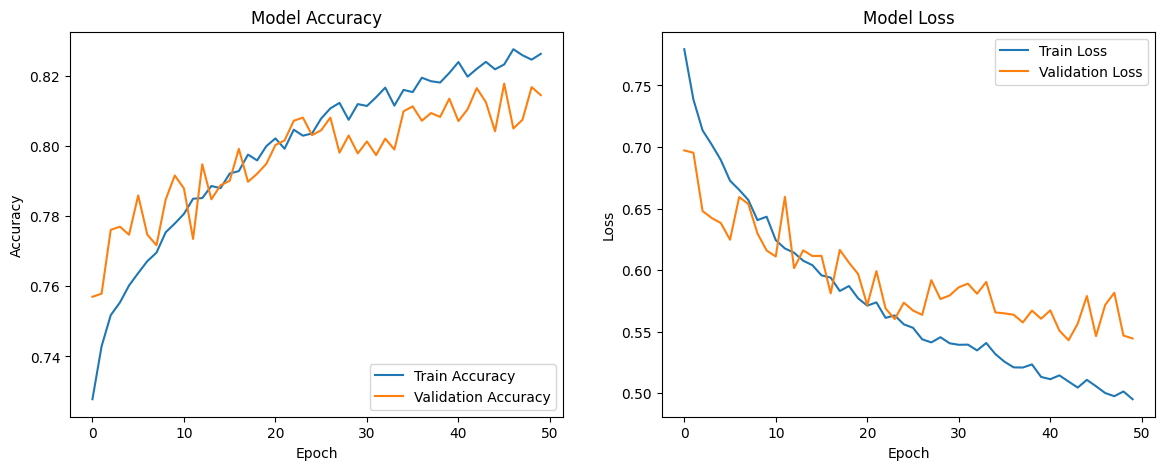

In [82]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()


In [83]:
pruned_target_model_by_filt_norm.save('pruned_target_by_filt_norm_flop60.h5')

In [84]:
keep_filt_conv3_by_filt_correlation = filter_to_keep(properties(model, 'conv3', 'filter_correlation'), 50)
keep_filt_conv4_by_filt_correlation = filter_to_keep(properties(model, 'conv4', 'filter_correlation'), 50)
keep_filt_conv5_by_filt_correlation = filter_to_keep(properties(model, 'conv5', 'filter_correlation'), 70)
keep_filt_conv6_by_filt_correlation = filter_to_keep(properties(model, 'conv6', 'filter_correlation'), 70)
keep_filt_conv7_by_filt_correlation = filter_to_keep(properties(model, 'conv7', 'filter_correlation'), 60)


In [85]:
pruned_target_model_by_filt_correlation = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv3_by_filt_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv3'),
        Conv2D(len(keep_filt_conv4_by_filt_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv5_by_filt_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv5'),
        Conv2D(len(keep_filt_conv6_by_filt_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv7_by_filt_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(len(keep_filt_conv7_by_filt_correlation), activation='relu',kernel_initializer='he_normal', name='fc1'),
        Dense(64, activation='relu',kernel_initializer='he_normal', name='fc2'),
        Dense(10, activation='softmax', name='output')
        ])

In [86]:
copy_weights_pruned(model, pruned_target_model_by_filt_correlation, [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ keep_filt_conv3_by_filt_correlation, keep_filt_conv4_by_filt_correlation, keep_filt_conv5_by_filt_correlation, keep_filt_conv6_by_filt_correlation, keep_filt_conv7_by_filt_correlation])

In [87]:
pruned_target_model_by_filt_correlation.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = pruned_target_model_by_filt_correlation.fit(train_images, train_labels, epochs=50, batch_size=64, validation_data=(val_images, val_labels))

Epoch 1/50


2024-11-01 13:57:27.922047: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout_28/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 5s 5ms/step - loss: 1.6653 - accuracy: 0.3622 - val_loss: 1.2428 - val_accuracy: 0.5454
Epoch 2/50
625/625 [==============================] - 3s 5ms/step - loss: 1.1898 - accuracy: 0.5647 - val_loss: 1.0144 - val_accuracy: 0.6353
Epoch 3/50
625/625 [==============================] - 3s 5ms/step - loss: 1.0297 - accuracy: 0.6302 - val_loss: 0.9083 - val_accuracy: 0.6753
Epoch 4/50
625/625 [==============================] - 3s 5ms/step - loss: 0.9493 - accuracy: 0.6633 - val_loss: 0.8551 - val_accuracy: 0.6999
Epoch 5/50
625/625 [==============================] - 3s 5ms/step - loss: 0.8797 - accuracy: 0.6904 - val_loss: 0.7945 - val_accuracy: 0.7162
Epoch 6/50
625/625 [==============================] - 3s 5ms/step - loss: 0.8430 - accuracy: 0.7028 - val_loss: 0.7675 - val_accuracy: 0.7302
Epoch 7/50
625/625 [==============================] - 3s 5ms/step - loss: 0.8047 - accuracy: 0.7140 - val_loss: 0.7815 - val_accuracy: 0.7267
Epoch 8/50
625/62

In [88]:
test_loss, test_acc = pruned_target_model_by_filt_correlation.evaluate(test_images, test_labels, verbose=2)


313/313 - 0s - loss: 0.6026 - accuracy: 0.7970 - 421ms/epoch - 1ms/step


In [89]:
train_loss, train_acc = pruned_target_model_by_filt_correlation.evaluate(train_images, train_labels, verbose=2)


1250/1250 - 2s - loss: 0.3470 - accuracy: 0.8850 - 2s/epoch - 1ms/step


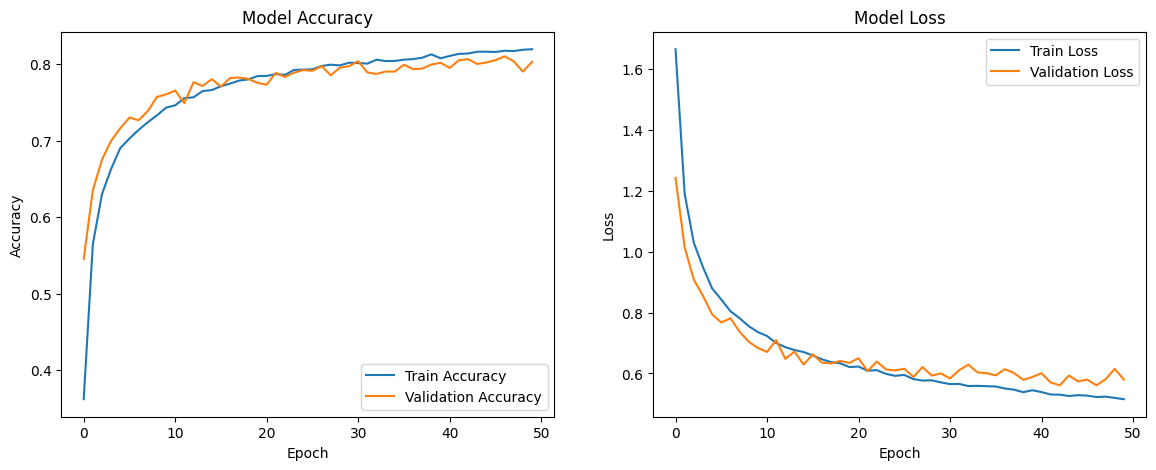

In [90]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

In [91]:
pruned_target_model_by_filt_correlation.save('pruned_target_by_filt_correlation_flop60.h5')

In [92]:
keep_filt_conv3_by_feature_map_correlation = filter_to_keep(properties(model, 'conv3', 'feature_map_correlation'), 50)
keep_filt_conv4_by_feature_map_correlation = filter_to_keep(properties(model, 'conv4', 'feature_map_correlation'), 50)
keep_filt_conv5_by_feature_map_correlation = filter_to_keep(properties(model, 'conv5', 'feature_map_correlation'), 70)
keep_filt_conv6_by_feature_map_correlation = filter_to_keep(properties(model, 'conv6', 'feature_map_correlation'), 70)
keep_filt_conv7_by_feature_map_correlation = filter_to_keep(properties(model, 'conv7', 'feature_map_correlation'), 60)

32/32 [==============================] - 0s 944us/step


In [93]:
pruned_target_model_by_feature_map_correlation = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv3_by_feature_map_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv3'),
        Conv2D(len(keep_filt_conv4_by_feature_map_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv5_by_feature_map_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv5'),
        Conv2D(len(keep_filt_conv6_by_feature_map_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv7_by_feature_map_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(len(keep_filt_conv7_by_feature_map_correlation), activation='relu',kernel_initializer='he_normal', name='fc1'),
        Dense(64, activation='relu',kernel_initializer='he_normal', name='fc2'),
        Dense(10, activation='softmax', name='output')
        ])

In [94]:
copy_weights_pruned(model, pruned_target_model_by_feature_map_correlation, [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ keep_filt_conv3_by_feature_map_correlation, keep_filt_conv4_by_feature_map_correlation, keep_filt_conv5_by_feature_map_correlation, keep_filt_conv6_by_feature_map_correlation, keep_filt_conv7_by_feature_map_correlation])

In [95]:
pruned_target_model_by_feature_map_correlation.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = pruned_target_model_by_feature_map_correlation.fit(train_images, train_labels, epochs=50, batch_size=64, validation_data=(val_images, val_labels))

Epoch 1/50


2024-11-01 14:00:10.194911: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_32/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 5s 5ms/step - loss: 1.6859 - accuracy: 0.3622 - val_loss: 1.3044 - val_accuracy: 0.5062
Epoch 2/50
625/625 [==============================] - 3s 5ms/step - loss: 1.1998 - accuracy: 0.5653 - val_loss: 1.0336 - val_accuracy: 0.6368
Epoch 3/50
625/625 [==============================] - 3s 5ms/step - loss: 1.0332 - accuracy: 0.6298 - val_loss: 0.9216 - val_accuracy: 0.6713
Epoch 4/50
625/625 [==============================] - 3s 5ms/step - loss: 0.9506 - accuracy: 0.6636 - val_loss: 0.8612 - val_accuracy: 0.6947
Epoch 5/50
625/625 [==============================] - 3s 5ms/step - loss: 0.8928 - accuracy: 0.6833 - val_loss: 0.7969 - val_accuracy: 0.7250
Epoch 6/50
625/625 [==============================] - 3s 5ms/step - loss: 0.8532 - accuracy: 0.7011 - val_loss: 0.7547 - val_accuracy: 0.7355
Epoch 7/50
625/625 [==============================] - 3s 5ms/step - loss: 0.8143 - accuracy: 0.7126 - val_loss: 0.7338 - val_accuracy: 0.7405
Epoch 8/50
625/62

In [96]:
test_loss, test_acc = pruned_target_model_by_feature_map_correlation.evaluate(test_images, test_labels, verbose=2)


313/313 - 0s - loss: 0.5763 - accuracy: 0.8045 - 433ms/epoch - 1ms/step


In [97]:
train_loss, train_acc = pruned_target_model_by_feature_map_correlation.evaluate(train_images, train_labels, verbose=2)


1250/1250 - 2s - loss: 0.3230 - accuracy: 0.8916 - 2s/epoch - 1ms/step


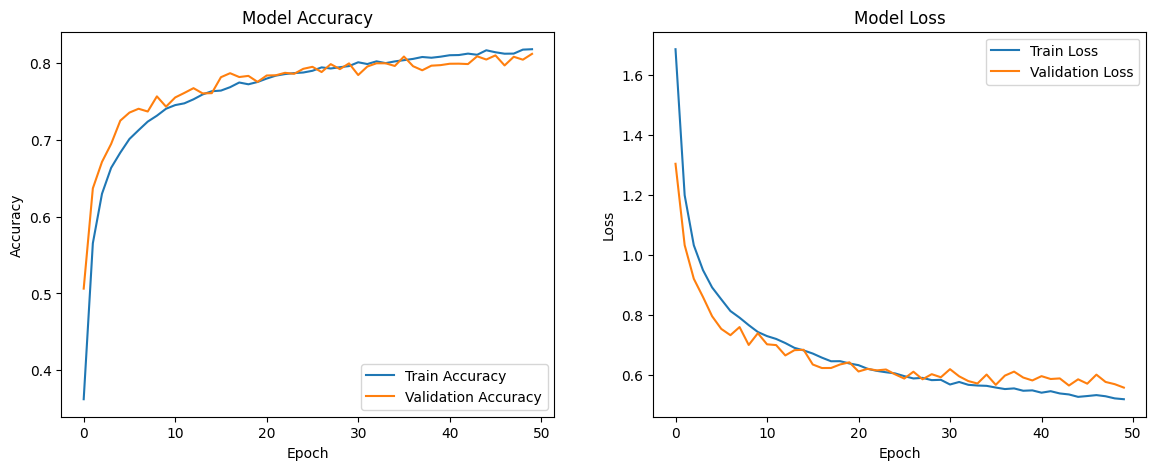

In [98]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

In [99]:
pruned_target_model_by_feature_map_correlation.save('pruned_target_by_feature_map_correlation_flop60.h5')

In [100]:
keep_filt_conv3_by_feature_map_dct = filter_to_keep(properties(model, 'conv3', 'feature_map_dct'), 50)
keep_filt_conv4_by_feature_map_dct = filter_to_keep(properties(model, 'conv4', 'feature_map_dct'), 50)
keep_filt_conv5_by_feature_map_dct = filter_to_keep(properties(model, 'conv5', 'feature_map_dct'), 70)
keep_filt_conv6_by_feature_map_dct = filter_to_keep(properties(model, 'conv6', 'feature_map_dct'), 70)
keep_filt_conv7_by_feature_map_dct = filter_to_keep(properties(model, 'conv7', 'feature_map_dct'), 60)

32/32 [==============================] - 0s 899us/step


In [101]:
pruned_target_model_by_feature_map_dct = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv3_by_feature_map_dct), (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv3'),
        Conv2D(len(keep_filt_conv4_by_feature_map_dct), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv5_by_feature_map_dct), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv5'),
        Conv2D(len(keep_filt_conv6_by_feature_map_dct), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv7_by_feature_map_dct), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(len(keep_filt_conv7_by_feature_map_dct), activation='relu',kernel_initializer='he_normal', name='fc1'),
        Dense(64, activation='relu',kernel_initializer='he_normal', name='fc2'),
        Dense(10, activation='softmax', name='output')
        ])

In [102]:
copy_weights_pruned(model, pruned_target_model_by_feature_map_dct, [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ keep_filt_conv3_by_feature_map_dct, keep_filt_conv4_by_feature_map_dct, keep_filt_conv5_by_feature_map_dct, keep_filt_conv6_by_feature_map_dct, keep_filt_conv7_by_feature_map_dct])

In [103]:
pruned_target_model_by_feature_map_dct.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = pruned_target_model_by_feature_map_dct.fit(train_images, train_labels, epochs=50, batch_size=64, validation_data=(val_images, val_labels))

Epoch 1/50


2024-11-01 14:03:45.597035: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_36/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 5s 5ms/step - loss: 1.6405 - accuracy: 0.3760 - val_loss: 1.2177 - val_accuracy: 0.5438
Epoch 2/50
625/625 [==============================] - 3s 5ms/step - loss: 1.1815 - accuracy: 0.5710 - val_loss: 1.0380 - val_accuracy: 0.6259
Epoch 3/50
625/625 [==============================] - 3s 5ms/step - loss: 1.0323 - accuracy: 0.6294 - val_loss: 0.9324 - val_accuracy: 0.6696
Epoch 4/50
625/625 [==============================] - 3s 5ms/step - loss: 0.9478 - accuracy: 0.6655 - val_loss: 0.8388 - val_accuracy: 0.7023
Epoch 5/50
625/625 [==============================] - 3s 5ms/step - loss: 0.8939 - accuracy: 0.6841 - val_loss: 0.8561 - val_accuracy: 0.6956
Epoch 6/50
625/625 [==============================] - 3s 5ms/step - loss: 0.8431 - accuracy: 0.7022 - val_loss: 0.7637 - val_accuracy: 0.7254
Epoch 7/50
625/625 [==============================] - 3s 5ms/step - loss: 0.8201 - accuracy: 0.7096 - val_loss: 0.7637 - val_accuracy: 0.7315
Epoch 8/50
625/62

In [104]:
test_loss, test_acc = pruned_target_model_by_feature_map_dct.evaluate(test_images, test_labels, verbose=2)


313/313 - 0s - loss: 0.6040 - accuracy: 0.7984 - 400ms/epoch - 1ms/step


In [105]:
train_loss, train_acc = pruned_target_model_by_feature_map_dct.evaluate(train_images, train_labels, verbose=2)


1250/1250 - 2s - loss: 0.3410 - accuracy: 0.8792 - 2s/epoch - 1ms/step


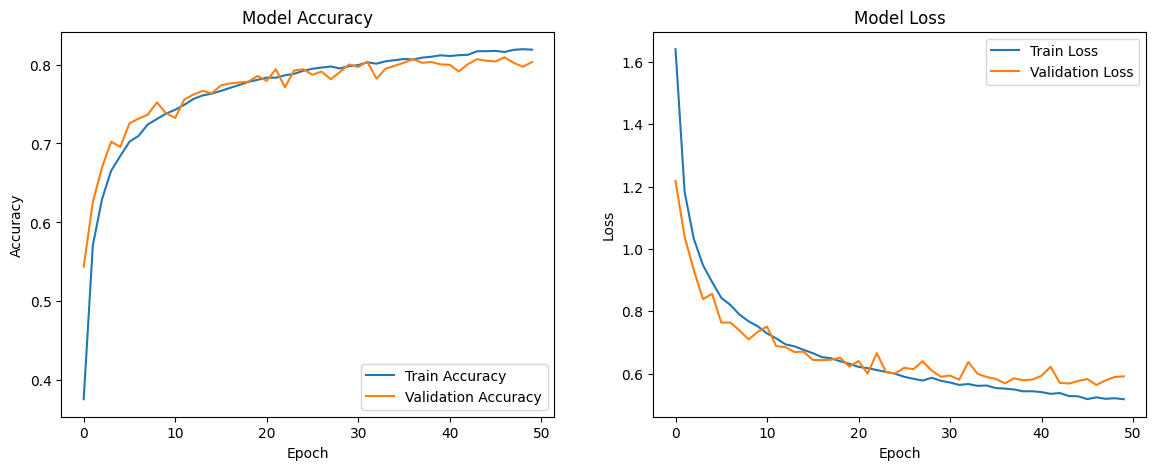

In [108]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

In [109]:
pruned_target_model_by_feature_map_dct.save('pruned_target_by_feature_map_dct_flop60.h5')

# flops 50%

In [110]:
keep_filt_conv3_by_filt_norm = filter_to_keep(properties(model, 'conv3', 'filter_norm'), 50)
keep_filt_conv4_by_filt_norm = filter_to_keep(properties(model, 'conv4', 'filter_norm'), 50)
keep_filt_conv5_by_filt_norm = filter_to_keep(properties(model, 'conv5', 'filter_norm'), 40)
keep_filt_conv6_by_filt_norm = filter_to_keep(properties(model, 'conv6', 'filter_norm'), 40)
keep_filt_conv7_by_filt_norm = filter_to_keep(properties(model, 'conv7', 'filter_norm'), 40)



In [111]:
'''pruned_target_model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=X.shape[1:], name='target_conv1'),
        MaxPooling2D((2,2), name='target_pool1'),
        Conv2D(len(keep_filt), (3,3), activation='relu', name='target_conv2'),
        MaxPooling2D((2,2), name='target_pool2'),
        Flatten(name='target_flatten'),
        Dense(len(keep_filt), activation='relu', name='target_fc1'),
        Dense(10, activation='softmax', name='target_output')
        ])'''

pruned_target_model_by_filt_norm = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv3_by_filt_norm), (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv3'),
        Conv2D(len(keep_filt_conv4_by_filt_norm), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv5_by_filt_norm), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv5'),
        Conv2D(len(keep_filt_conv6_by_filt_norm), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv7_by_filt_norm), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(len(keep_filt_conv7_by_filt_norm), activation='relu',kernel_initializer='he_normal', name='fc1'),
        Dense(64, activation='relu',kernel_initializer='he_normal', name='fc2'),
        Dense(10, activation='softmax', name='output')
        ])

In [112]:
copy_weights_pruned(model, pruned_target_model_by_filt_norm, [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ keep_filt_conv3_by_filt_norm, keep_filt_conv4_by_filt_norm, keep_filt_conv5_by_filt_norm, keep_filt_conv6_by_filt_norm, keep_filt_conv7_by_filt_norm])
pruned_target_model_by_filt_norm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [113]:
get_flops(pruned_target_model_by_filt_norm, train_images.shape)


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

2024-11-01 14:07:02.854474: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-01 14:07:02.854563: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-11-01 14:07:02.854618: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-11-01 14:07:02.854878: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-01 14:07:02.854993: I external/local_xla/xla/stream_executor/cuda/cuda_e

1740738160000

In [114]:
pruned_target_model_by_filt_norm.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 dropout_40 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv3 (Conv2D)              (None, 16, 16, 32)        9248      
                                                                 
 conv4 (Conv2D)              (None, 16, 16, 32)        9248      
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 32)        

In [115]:
pruned_target_model_by_filt_norm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = pruned_target_model_by_filt_norm.fit(train_images, train_labels, epochs=50, batch_size=64, validation_data=(val_images, val_labels))

Epoch 1/50


2024-11-01 14:07:11.378823: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_10/dropout_40/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 6s 6ms/step - loss: 1.5312 - accuracy: 0.4224 - val_loss: 1.1080 - val_accuracy: 0.6068
Epoch 2/50
625/625 [==============================] - 4s 6ms/step - loss: 1.0751 - accuracy: 0.6146 - val_loss: 0.9295 - val_accuracy: 0.6726
Epoch 3/50
625/625 [==============================] - 3s 5ms/step - loss: 0.9406 - accuracy: 0.6686 - val_loss: 0.8657 - val_accuracy: 0.6957
Epoch 4/50
625/625 [==============================] - 4s 6ms/step - loss: 0.8637 - accuracy: 0.6957 - val_loss: 0.7961 - val_accuracy: 0.7242
Epoch 5/50
625/625 [==============================] - 3s 6ms/step - loss: 0.8067 - accuracy: 0.7171 - val_loss: 0.7538 - val_accuracy: 0.7361
Epoch 6/50
625/625 [==============================] - 3s 5ms/step - loss: 0.7685 - accuracy: 0.7318 - val_loss: 0.7237 - val_accuracy: 0.7476
Epoch 7/50
625/625 [==============================] - 4s 6ms/step - loss: 0.7329 - accuracy: 0.7448 - val_loss: 0.7127 - val_accuracy: 0.7575
Epoch 8/50
625/62

In [116]:
test_loss, test_acc = pruned_target_model_by_filt_norm.evaluate(test_images, test_labels, verbose=2)


313/313 - 0s - loss: 0.5638 - accuracy: 0.8168 - 476ms/epoch - 2ms/step


In [117]:
train_loss, train_acc = pruned_target_model_by_filt_norm.evaluate(train_images, train_labels, verbose=2)


1250/1250 - 2s - loss: 0.2419 - accuracy: 0.9210 - 2s/epoch - 1ms/step


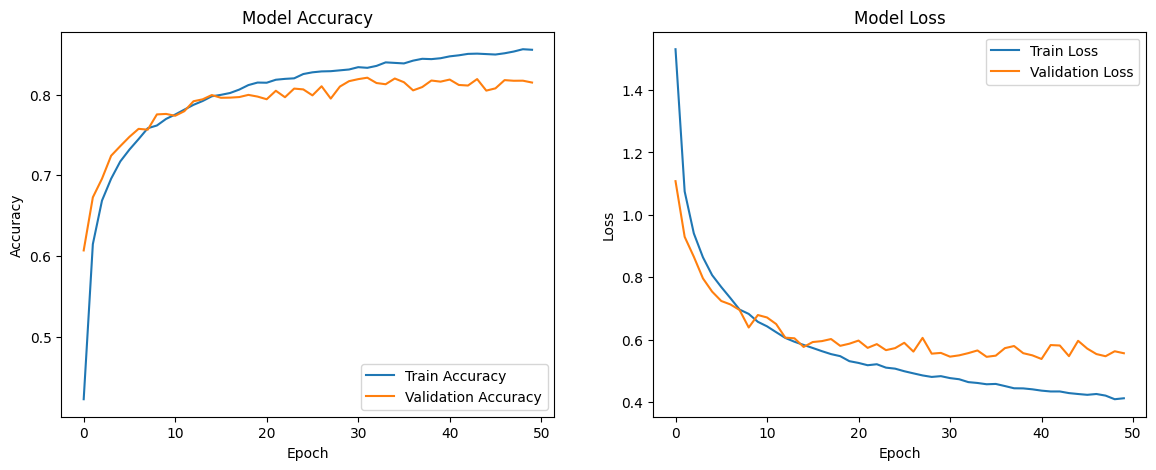

In [118]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()


In [119]:
pruned_target_model_by_filt_norm.save('pruned_target_by_filt_norm_flop50.h5')

In [120]:
keep_filt_conv3_by_filt_correlation = filter_to_keep(properties(model, 'conv3', 'filter_correlation'), 50)
keep_filt_conv4_by_filt_correlation = filter_to_keep(properties(model, 'conv4', 'filter_correlation'), 50)
keep_filt_conv5_by_filt_correlation = filter_to_keep(properties(model, 'conv5', 'filter_correlation'), 40)
keep_filt_conv6_by_filt_correlation = filter_to_keep(properties(model, 'conv6', 'filter_correlation'), 40)
keep_filt_conv7_by_filt_correlation = filter_to_keep(properties(model, 'conv7', 'filter_correlation'), 40)


In [121]:
pruned_target_model_by_filt_correlation = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv3_by_filt_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv3'),
        Conv2D(len(keep_filt_conv4_by_filt_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv5_by_filt_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv5'),
        Conv2D(len(keep_filt_conv6_by_filt_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv7_by_filt_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(len(keep_filt_conv7_by_filt_correlation), activation='relu',kernel_initializer='he_normal', name='fc1'),
        Dense(64, activation='relu',kernel_initializer='he_normal', name='fc2'),
        Dense(10, activation='softmax', name='output')
        ])

In [122]:
copy_weights_pruned(model, pruned_target_model_by_filt_correlation, [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ keep_filt_conv3_by_filt_correlation, keep_filt_conv4_by_filt_correlation, keep_filt_conv5_by_filt_correlation, keep_filt_conv6_by_filt_correlation, keep_filt_conv7_by_filt_correlation])

In [123]:
pruned_target_model_by_filt_correlation.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = pruned_target_model_by_filt_correlation.fit(train_images, train_labels, epochs=50, batch_size=64, validation_data=(val_images, val_labels))

Epoch 1/50


2024-11-01 14:10:11.850973: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_11/dropout_44/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 5s 5ms/step - loss: 1.5799 - accuracy: 0.4057 - val_loss: 1.1169 - val_accuracy: 0.5963
Epoch 2/50
625/625 [==============================] - 3s 5ms/step - loss: 1.1025 - accuracy: 0.6052 - val_loss: 1.0185 - val_accuracy: 0.6419
Epoch 3/50
625/625 [==============================] - 4s 6ms/step - loss: 0.9587 - accuracy: 0.6604 - val_loss: 0.8452 - val_accuracy: 0.7015
Epoch 4/50
625/625 [==============================] - 4s 6ms/step - loss: 0.8765 - accuracy: 0.6886 - val_loss: 0.7752 - val_accuracy: 0.7272
Epoch 5/50
625/625 [==============================] - 4s 6ms/step - loss: 0.8270 - accuracy: 0.7091 - val_loss: 0.7479 - val_accuracy: 0.7348
Epoch 6/50
625/625 [==============================] - 3s 5ms/step - loss: 0.7764 - accuracy: 0.7269 - val_loss: 0.7306 - val_accuracy: 0.7434
Epoch 7/50
625/625 [==============================] - 4s 6ms/step - loss: 0.7428 - accuracy: 0.7405 - val_loss: 0.6933 - val_accuracy: 0.7542
Epoch 8/50
625/62

In [124]:
test_loss, test_acc = pruned_target_model_by_filt_correlation.evaluate(test_images, test_labels, verbose=2)


313/313 - 0s - loss: 0.5602 - accuracy: 0.8179 - 426ms/epoch - 1ms/step


In [125]:
train_loss, train_acc = pruned_target_model_by_filt_correlation.evaluate(train_images, train_labels, verbose=2)


1250/1250 - 2s - loss: 0.2305 - accuracy: 0.9291 - 2s/epoch - 1ms/step


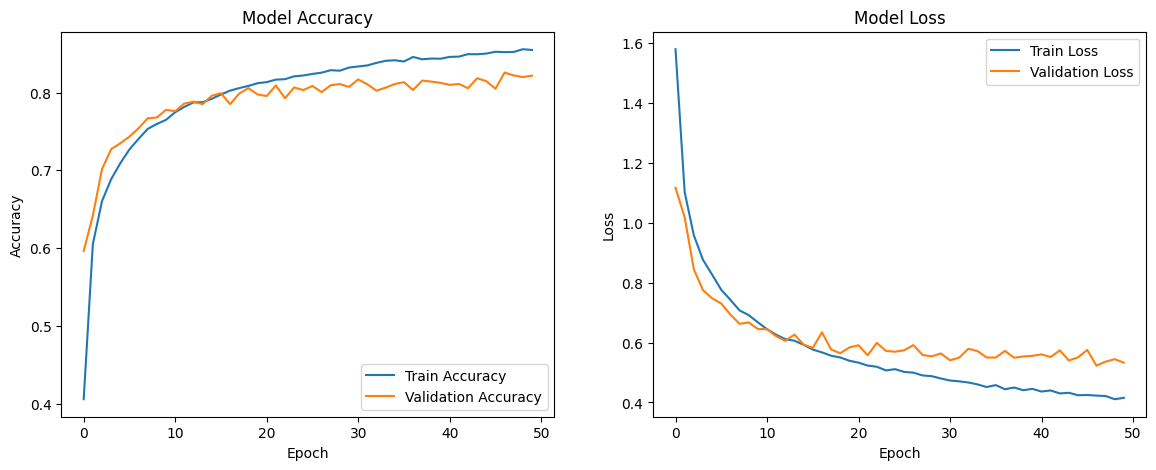

In [126]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

In [127]:
pruned_target_model_by_filt_correlation.save('pruned_target_by_filt_correlation_flop50.h5')

In [128]:
keep_filt_conv3_by_feature_map_correlation = filter_to_keep(properties(model, 'conv3', 'feature_map_correlation'), 50)
keep_filt_conv4_by_feature_map_correlation = filter_to_keep(properties(model, 'conv4', 'feature_map_correlation'), 50)
keep_filt_conv5_by_feature_map_correlation = filter_to_keep(properties(model, 'conv5', 'feature_map_correlation'), 40)
keep_filt_conv6_by_feature_map_correlation = filter_to_keep(properties(model, 'conv6', 'feature_map_correlation'), 40)
keep_filt_conv7_by_feature_map_correlation = filter_to_keep(properties(model, 'conv7', 'feature_map_correlation'), 40)

32/32 [==============================] - 0s 964us/step


In [129]:
pruned_target_model_by_feature_map_correlation = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv3_by_feature_map_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv3'),
        Conv2D(len(keep_filt_conv4_by_feature_map_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv5_by_feature_map_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv5'),
        Conv2D(len(keep_filt_conv6_by_feature_map_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv7_by_feature_map_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(len(keep_filt_conv7_by_feature_map_correlation), activation='relu',kernel_initializer='he_normal', name='fc1'),
        Dense(64, activation='relu',kernel_initializer='he_normal', name='fc2'),
        Dense(10, activation='softmax', name='output')
        ])

In [130]:
copy_weights_pruned(model, pruned_target_model_by_feature_map_correlation, [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ keep_filt_conv3_by_feature_map_correlation, keep_filt_conv4_by_feature_map_correlation, keep_filt_conv5_by_feature_map_correlation, keep_filt_conv6_by_feature_map_correlation, keep_filt_conv7_by_feature_map_correlation])

In [131]:
pruned_target_model_by_feature_map_correlation.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = pruned_target_model_by_feature_map_correlation.fit(train_images, train_labels, epochs=50, batch_size=64, validation_data=(val_images, val_labels))

Epoch 1/50


2024-11-01 14:13:11.968275: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_12/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 5s 6ms/step - loss: 1.6113 - accuracy: 0.3938 - val_loss: 1.1658 - val_accuracy: 0.5628
Epoch 2/50
625/625 [==============================] - 4s 6ms/step - loss: 1.1048 - accuracy: 0.6064 - val_loss: 0.9471 - val_accuracy: 0.6771
Epoch 3/50
625/625 [==============================] - 3s 5ms/step - loss: 0.9331 - accuracy: 0.6698 - val_loss: 0.8191 - val_accuracy: 0.7124
Epoch 4/50
625/625 [==============================] - 3s 5ms/step - loss: 0.8528 - accuracy: 0.7045 - val_loss: 0.7756 - val_accuracy: 0.7266
Epoch 5/50
625/625 [==============================] - 3s 5ms/step - loss: 0.7989 - accuracy: 0.7233 - val_loss: 0.7464 - val_accuracy: 0.7367
Epoch 6/50
625/625 [==============================] - 4s 6ms/step - loss: 0.7540 - accuracy: 0.7383 - val_loss: 0.6960 - val_accuracy: 0.7573
Epoch 7/50
625/625 [==============================] - 3s 6ms/step - loss: 0.7232 - accuracy: 0.7483 - val_loss: 0.6929 - val_accuracy: 0.7566
Epoch 8/50
625/62

In [132]:
test_loss, test_acc = pruned_target_model_by_feature_map_correlation.evaluate(test_images, test_labels, verbose=2)


313/313 - 0s - loss: 0.5719 - accuracy: 0.8140 - 421ms/epoch - 1ms/step


In [133]:
train_loss, train_acc = pruned_target_model_by_feature_map_correlation.evaluate(train_images, train_labels, verbose=2)


1250/1250 - 2s - loss: 0.2024 - accuracy: 0.9381 - 2s/epoch - 1ms/step


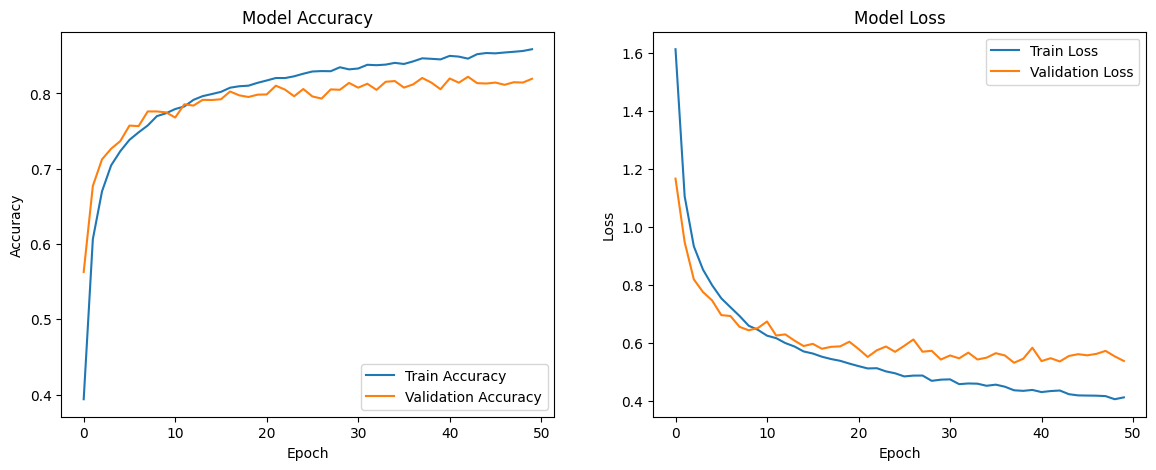

In [134]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

In [135]:
pruned_target_model_by_feature_map_correlation.save('pruned_target_by_feature_map_correlation_flop50.h5')

In [137]:
keep_filt_conv3_by_feature_map_dct = filter_to_keep(properties(model, 'conv3', 'feature_map_dct'), 50)
keep_filt_conv4_by_feature_map_dct = filter_to_keep(properties(model, 'conv4', 'feature_map_dct'), 50)
keep_filt_conv5_by_feature_map_dct = filter_to_keep(properties(model, 'conv5', 'feature_map_dct'), 40)
keep_filt_conv6_by_feature_map_dct = filter_to_keep(properties(model, 'conv6', 'feature_map_dct'), 40)
keep_filt_conv7_by_feature_map_dct = filter_to_keep(properties(model, 'conv7', 'feature_map_dct'), 40)

32/32 [==============================] - 0s 949us/step


In [138]:
pruned_target_model_by_feature_map_dct = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv3_by_feature_map_dct), (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv3'),
        Conv2D(len(keep_filt_conv4_by_feature_map_dct), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv5_by_feature_map_dct), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv5'),
        Conv2D(len(keep_filt_conv6_by_feature_map_dct), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv7_by_feature_map_dct), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(len(keep_filt_conv7_by_feature_map_dct), activation='relu',kernel_initializer='he_normal', name='fc1'),
        Dense(64, activation='relu',kernel_initializer='he_normal', name='fc2'),
        Dense(10, activation='softmax', name='output')
        ])

In [139]:
copy_weights_pruned(model, pruned_target_model_by_feature_map_dct, [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ keep_filt_conv3_by_feature_map_dct, keep_filt_conv4_by_feature_map_dct, keep_filt_conv5_by_feature_map_dct, keep_filt_conv6_by_feature_map_dct, keep_filt_conv7_by_feature_map_dct])

In [140]:
pruned_target_model_by_feature_map_dct.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = pruned_target_model_by_feature_map_dct.fit(train_images, train_labels, epochs=50, batch_size=64, validation_data=(val_images, val_labels))

Epoch 1/50


2024-11-01 14:17:46.680287: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_13/dropout_52/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 5s 6ms/step - loss: 1.5476 - accuracy: 0.4229 - val_loss: 1.1312 - val_accuracy: 0.5950
Epoch 2/50
625/625 [==============================] - 4s 6ms/step - loss: 1.0683 - accuracy: 0.6181 - val_loss: 0.8964 - val_accuracy: 0.6826
Epoch 3/50
625/625 [==============================] - 4s 6ms/step - loss: 0.9286 - accuracy: 0.6707 - val_loss: 0.8328 - val_accuracy: 0.7083
Epoch 4/50
625/625 [==============================] - 3s 5ms/step - loss: 0.8487 - accuracy: 0.7015 - val_loss: 0.7718 - val_accuracy: 0.7310
Epoch 5/50
625/625 [==============================] - 3s 5ms/step - loss: 0.7872 - accuracy: 0.7220 - val_loss: 0.7305 - val_accuracy: 0.7432
Epoch 6/50
625/625 [==============================] - 3s 6ms/step - loss: 0.7580 - accuracy: 0.7358 - val_loss: 0.6921 - val_accuracy: 0.7575
Epoch 7/50
625/625 [==============================] - 3s 5ms/step - loss: 0.7141 - accuracy: 0.7520 - val_loss: 0.6889 - val_accuracy: 0.7629
Epoch 8/50
625/62

In [141]:
test_loss, test_acc = pruned_target_model_by_feature_map_dct.evaluate(test_images, test_labels, verbose=2)


313/313 - 0s - loss: 0.5735 - accuracy: 0.8148 - 428ms/epoch - 1ms/step


In [142]:
train_loss, train_acc = pruned_target_model_by_feature_map_dct.evaluate(train_images, train_labels, verbose=2)


1250/1250 - 2s - loss: 0.2169 - accuracy: 0.9298 - 2s/epoch - 1ms/step


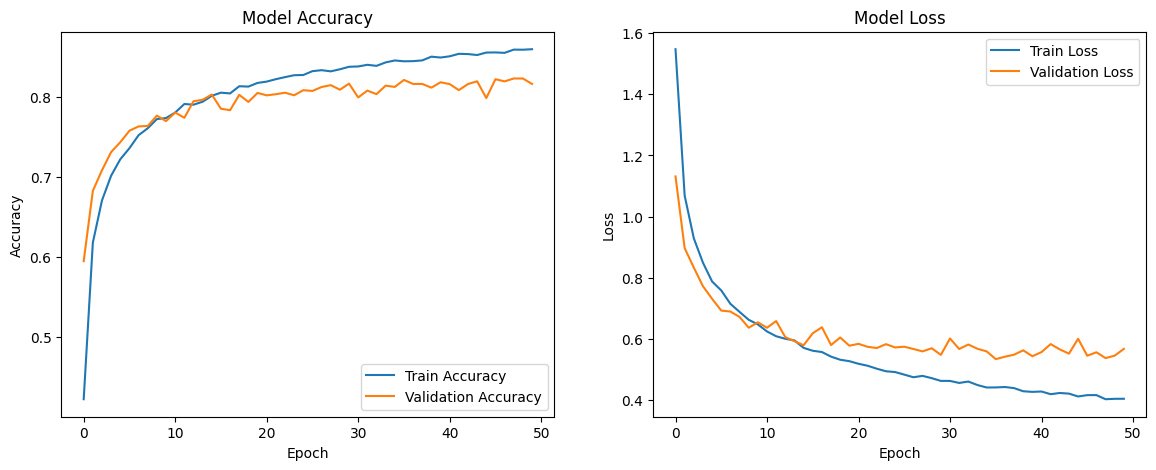

In [143]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

In [144]:
pruned_target_model_by_feature_map_dct.save('pruned_target_by_feature_map_dct_flop50.h5')

# flops 40%

In [145]:
keep_filt_conv3_by_filt_norm = filter_to_keep(properties(model, 'conv3', 'filter_norm'), 50)
keep_filt_conv4_by_filt_norm = filter_to_keep(properties(model, 'conv4', 'filter_norm'), 50)
keep_filt_conv5_by_filt_norm = filter_to_keep(properties(model, 'conv5', 'filter_norm'), 20)
keep_filt_conv6_by_filt_norm = filter_to_keep(properties(model, 'conv6', 'filter_norm'), 20)
keep_filt_conv7_by_filt_norm = filter_to_keep(properties(model, 'conv7', 'filter_norm'), 20)



In [146]:
'''pruned_target_model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=X.shape[1:], name='target_conv1'),
        MaxPooling2D((2,2), name='target_pool1'),
        Conv2D(len(keep_filt), (3,3), activation='relu', name='target_conv2'),
        MaxPooling2D((2,2), name='target_pool2'),
        Flatten(name='target_flatten'),
        Dense(len(keep_filt), activation='relu', name='target_fc1'),
        Dense(10, activation='softmax', name='target_output')
        ])'''

pruned_target_model_by_filt_norm = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv3_by_filt_norm), (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv3'),
        Conv2D(len(keep_filt_conv4_by_filt_norm), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv5_by_filt_norm), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv5'),
        Conv2D(len(keep_filt_conv6_by_filt_norm), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv7_by_filt_norm), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(len(keep_filt_conv7_by_filt_norm), activation='relu',kernel_initializer='he_normal', name='fc1'),
        Dense(64, activation='relu',kernel_initializer='he_normal', name='fc2'),
        Dense(10, activation='softmax', name='output')
        ])

In [147]:
copy_weights_pruned(model, pruned_target_model_by_filt_norm, [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ keep_filt_conv3_by_filt_norm, keep_filt_conv4_by_filt_norm, keep_filt_conv5_by_filt_norm, keep_filt_conv6_by_filt_norm, keep_filt_conv7_by_filt_norm])
pruned_target_model_by_filt_norm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [148]:
get_flops(pruned_target_model_by_filt_norm, train_images.shape)


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================


2024-11-01 14:21:15.819950: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-01 14:21:15.820112: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-11-01 14:21:15.820224: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-11-01 14:21:15.820567: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-01 14:21:15.820972: I external/local_xla/xla/stream_executor/cuda/cuda_e

2094468520000


Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profile:
node name | # float_ops
Conv2D                   2073.95b float_ops (100.00%, 99.02%)
MatMul                   14.55b float_ops (0.98%, 0.69%)
BiasAdd                  3.94b float_ops (0.29%, 0.19%)
MaxPool                  2.03b float_ops (0.10%, 0.10%)
Softmax                  2.00m float_ops (0.00%, 0.00%)

======================End of Report==========================


In [149]:
pruned_target_model_by_filt_norm.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 dropout_56 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv3 (Conv2D)              (None, 16, 16, 32)        9248      
                                                                 
 conv4 (Conv2D)              (None, 16, 16, 32)        9248      
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 32)        

In [150]:
pruned_target_model_by_filt_norm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = pruned_target_model_by_filt_norm.fit(train_images, train_labels, epochs=50, batch_size=64, validation_data=(val_images, val_labels))

Epoch 1/50


2024-11-01 14:21:24.488126: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_14/dropout_56/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 6s 6ms/step - loss: 1.5881 - accuracy: 0.3999 - val_loss: 1.0995 - val_accuracy: 0.5966
Epoch 2/50
625/625 [==============================] - 4s 6ms/step - loss: 1.0650 - accuracy: 0.6187 - val_loss: 0.9121 - val_accuracy: 0.6669
Epoch 3/50
625/625 [==============================] - 3s 6ms/step - loss: 0.9199 - accuracy: 0.6761 - val_loss: 0.8496 - val_accuracy: 0.6990
Epoch 4/50
625/625 [==============================] - 4s 6ms/step - loss: 0.8378 - accuracy: 0.7040 - val_loss: 0.7859 - val_accuracy: 0.7186
Epoch 5/50
625/625 [==============================] - 4s 6ms/step - loss: 0.7783 - accuracy: 0.7265 - val_loss: 0.6990 - val_accuracy: 0.7527
Epoch 6/50
625/625 [==============================] - 4s 6ms/step - loss: 0.7361 - accuracy: 0.7442 - val_loss: 0.7551 - val_accuracy: 0.7389
Epoch 7/50
625/625 [==============================] - 4s 6ms/step - loss: 0.7038 - accuracy: 0.7532 - val_loss: 0.6807 - val_accuracy: 0.7695
Epoch 8/50
625/62

In [151]:
test_loss, test_acc = pruned_target_model_by_filt_norm.evaluate(test_images, test_labels, verbose=2)


313/313 - 1s - loss: 0.5726 - accuracy: 0.8134 - 504ms/epoch - 2ms/step


In [152]:
train_loss, train_acc = pruned_target_model_by_filt_norm.evaluate(train_images, train_labels, verbose=2)


1250/1250 - 2s - loss: 0.1790 - accuracy: 0.9495 - 2s/epoch - 1ms/step


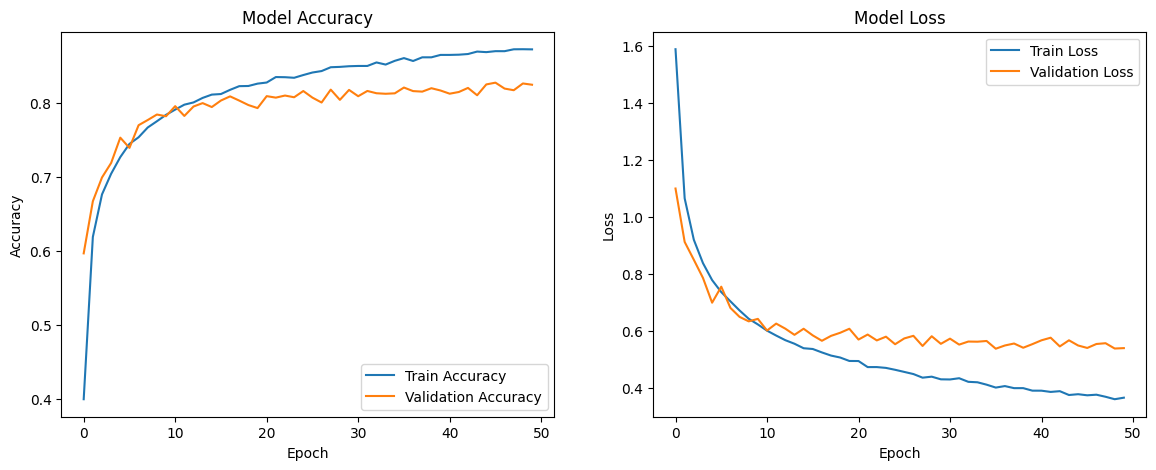

In [153]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()


In [154]:
pruned_target_model_by_filt_norm.save('pruned_target_by_filt_norm_flop40.h5')

In [155]:
keep_filt_conv3_by_filt_correlation = filter_to_keep(properties(model, 'conv3', 'filter_correlation'), 50)
keep_filt_conv4_by_filt_correlation = filter_to_keep(properties(model, 'conv4', 'filter_correlation'), 50)
keep_filt_conv5_by_filt_correlation = filter_to_keep(properties(model, 'conv5', 'filter_correlation'), 20)
keep_filt_conv6_by_filt_correlation = filter_to_keep(properties(model, 'conv6', 'filter_correlation'), 20)
keep_filt_conv7_by_filt_correlation = filter_to_keep(properties(model, 'conv7', 'filter_correlation'), 20)


In [156]:
pruned_target_model_by_filt_correlation = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv3_by_filt_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv3'),
        Conv2D(len(keep_filt_conv4_by_filt_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv5_by_filt_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv5'),
        Conv2D(len(keep_filt_conv6_by_filt_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv7_by_filt_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(len(keep_filt_conv7_by_filt_correlation), activation='relu',kernel_initializer='he_normal', name='fc1'),
        Dense(64, activation='relu',kernel_initializer='he_normal', name='fc2'),
        Dense(10, activation='softmax', name='output')
        ])

In [157]:
copy_weights_pruned(model, pruned_target_model_by_filt_correlation, [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ keep_filt_conv3_by_filt_correlation, keep_filt_conv4_by_filt_correlation, keep_filt_conv5_by_filt_correlation, keep_filt_conv6_by_filt_correlation, keep_filt_conv7_by_filt_correlation])

In [158]:
pruned_target_model_by_filt_correlation.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = pruned_target_model_by_filt_correlation.fit(train_images, train_labels, epochs=50, batch_size=64, validation_data=(val_images, val_labels))

Epoch 1/50


2024-11-01 14:24:37.273415: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_15/dropout_60/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 5s 6ms/step - loss: 1.5709 - accuracy: 0.4083 - val_loss: 1.0592 - val_accuracy: 0.6077
Epoch 2/50
625/625 [==============================] - 3s 6ms/step - loss: 1.0522 - accuracy: 0.6259 - val_loss: 0.8932 - val_accuracy: 0.6788
Epoch 3/50
625/625 [==============================] - 4s 6ms/step - loss: 0.9027 - accuracy: 0.6834 - val_loss: 0.8195 - val_accuracy: 0.7104
Epoch 4/50
625/625 [==============================] - 4s 7ms/step - loss: 0.8261 - accuracy: 0.7085 - val_loss: 0.7855 - val_accuracy: 0.7185
Epoch 5/50
625/625 [==============================] - 4s 6ms/step - loss: 0.7695 - accuracy: 0.7320 - val_loss: 0.6878 - val_accuracy: 0.7586
Epoch 6/50
625/625 [==============================] - 4s 6ms/step - loss: 0.7214 - accuracy: 0.7492 - val_loss: 0.6730 - val_accuracy: 0.7646
Epoch 7/50
625/625 [==============================] - 4s 7ms/step - loss: 0.6927 - accuracy: 0.7573 - val_loss: 0.6633 - val_accuracy: 0.7696
Epoch 8/50
625/62

In [159]:
test_loss, test_acc = pruned_target_model_by_filt_correlation.evaluate(test_images, test_labels, verbose=2)


313/313 - 0s - loss: 0.5688 - accuracy: 0.8192 - 443ms/epoch - 1ms/step


In [160]:
train_loss, train_acc = pruned_target_model_by_filt_correlation.evaluate(train_images, train_labels, verbose=2)


1250/1250 - 2s - loss: 0.1668 - accuracy: 0.9537 - 2s/epoch - 1ms/step


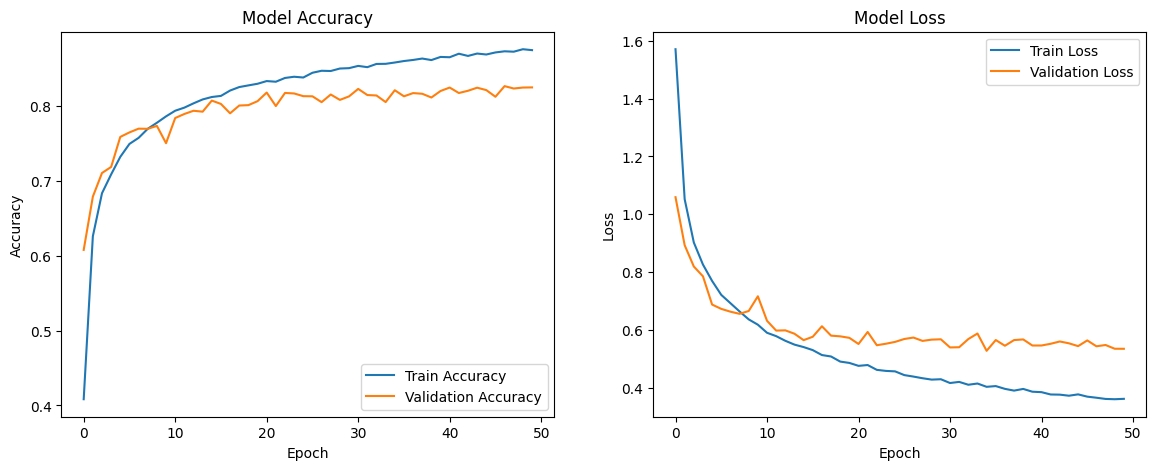

In [161]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

In [162]:
pruned_target_model_by_filt_correlation.save('pruned_target_by_filt_correlation_flop40.h5')

In [163]:
keep_filt_conv3_by_feature_map_correlation = filter_to_keep(properties(model, 'conv3', 'feature_map_correlation'), 50)
keep_filt_conv4_by_feature_map_correlation = filter_to_keep(properties(model, 'conv4', 'feature_map_correlation'), 50)
keep_filt_conv5_by_feature_map_correlation = filter_to_keep(properties(model, 'conv5', 'feature_map_correlation'), 20)
keep_filt_conv6_by_feature_map_correlation = filter_to_keep(properties(model, 'conv6', 'feature_map_correlation'), 20)
keep_filt_conv7_by_feature_map_correlation = filter_to_keep(properties(model, 'conv7', 'feature_map_correlation'), 20)

32/32 [==============================] - 0s 946us/step


In [164]:
pruned_target_model_by_feature_map_correlation = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv3_by_feature_map_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv3'),
        Conv2D(len(keep_filt_conv4_by_feature_map_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv5_by_feature_map_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv5'),
        Conv2D(len(keep_filt_conv6_by_feature_map_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv7_by_feature_map_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(len(keep_filt_conv7_by_feature_map_correlation), activation='relu',kernel_initializer='he_normal', name='fc1'),
        Dense(64, activation='relu',kernel_initializer='he_normal', name='fc2'),
        Dense(10, activation='softmax', name='output')
        ])

In [165]:
copy_weights_pruned(model, pruned_target_model_by_feature_map_correlation, [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ keep_filt_conv3_by_feature_map_correlation, keep_filt_conv4_by_feature_map_correlation, keep_filt_conv5_by_feature_map_correlation, keep_filt_conv6_by_feature_map_correlation, keep_filt_conv7_by_feature_map_correlation])

In [166]:
pruned_target_model_by_feature_map_correlation.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = pruned_target_model_by_feature_map_correlation.fit(train_images, train_labels, epochs=50, batch_size=64, validation_data=(val_images, val_labels))

Epoch 1/50


2024-11-01 14:27:50.106979: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/dropout_64/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 6s 7ms/step - loss: 1.5574 - accuracy: 0.4110 - val_loss: 1.1510 - val_accuracy: 0.5943
Epoch 2/50
625/625 [==============================] - 4s 6ms/step - loss: 1.0677 - accuracy: 0.6195 - val_loss: 0.8954 - val_accuracy: 0.6794
Epoch 3/50
625/625 [==============================] - 4s 6ms/step - loss: 0.9185 - accuracy: 0.6742 - val_loss: 0.8543 - val_accuracy: 0.6995
Epoch 4/50
625/625 [==============================] - 4s 6ms/step - loss: 0.8398 - accuracy: 0.7083 - val_loss: 0.7626 - val_accuracy: 0.7346
Epoch 5/50
625/625 [==============================] - 4s 6ms/step - loss: 0.7715 - accuracy: 0.7286 - val_loss: 0.7052 - val_accuracy: 0.7472
Epoch 6/50
625/625 [==============================] - 3s 6ms/step - loss: 0.7292 - accuracy: 0.7451 - val_loss: 0.7209 - val_accuracy: 0.7457
Epoch 7/50
625/625 [==============================] - 3s 6ms/step - loss: 0.6937 - accuracy: 0.7582 - val_loss: 0.6569 - val_accuracy: 0.7694
Epoch 8/50
625/62

In [167]:
test_loss, test_acc = pruned_target_model_by_feature_map_correlation.evaluate(test_images, test_labels, verbose=2)


313/313 - 0s - loss: 0.5944 - accuracy: 0.8166 - 443ms/epoch - 1ms/step


In [168]:
train_loss, train_acc = pruned_target_model_by_feature_map_correlation.evaluate(train_images, train_labels, verbose=2)


1250/1250 - 2s - loss: 0.1689 - accuracy: 0.9477 - 2s/epoch - 1ms/step


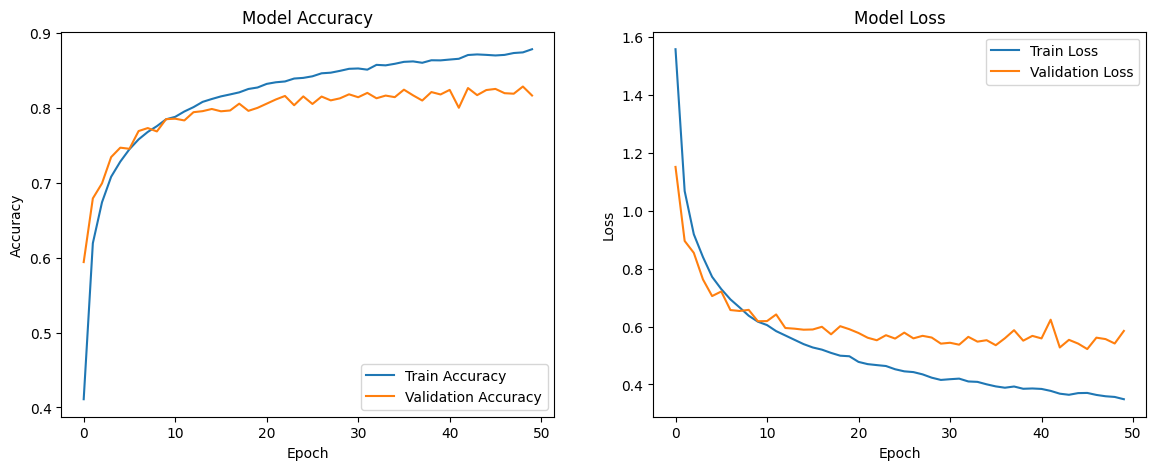

In [169]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

In [170]:
pruned_target_model_by_feature_map_correlation.save('pruned_target_by_feature_map_correlation_flop40.h5')

In [171]:
keep_filt_conv3_by_feature_map_dct = filter_to_keep(properties(model, 'conv3', 'feature_map_dct'), 50)
keep_filt_conv4_by_feature_map_dct = filter_to_keep(properties(model, 'conv4', 'feature_map_dct'), 50)
keep_filt_conv5_by_feature_map_dct = filter_to_keep(properties(model, 'conv5', 'feature_map_dct'), 20)
keep_filt_conv6_by_feature_map_dct = filter_to_keep(properties(model, 'conv6', 'feature_map_dct'), 20)
keep_filt_conv7_by_feature_map_dct = filter_to_keep(properties(model, 'conv7', 'feature_map_dct'), 20)

32/32 [==============================] - 0s 958us/step


In [172]:
pruned_target_model_by_feature_map_dct = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv3_by_feature_map_dct), (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv3'),
        Conv2D(len(keep_filt_conv4_by_feature_map_dct), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv5_by_feature_map_dct), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv5'),
        Conv2D(len(keep_filt_conv6_by_feature_map_dct), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv7_by_feature_map_dct), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(len(keep_filt_conv7_by_feature_map_dct), activation='relu',kernel_initializer='he_normal', name='fc1'),
        Dense(64, activation='relu',kernel_initializer='he_normal', name='fc2'),
        Dense(10, activation='softmax', name='output')
        ])

In [173]:
copy_weights_pruned(model, pruned_target_model_by_feature_map_dct, [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ keep_filt_conv3_by_feature_map_dct, keep_filt_conv4_by_feature_map_dct, keep_filt_conv5_by_feature_map_dct, keep_filt_conv6_by_feature_map_dct, keep_filt_conv7_by_feature_map_dct])

In [174]:
pruned_target_model_by_feature_map_dct.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = pruned_target_model_by_feature_map_dct.fit(train_images, train_labels, epochs=50, batch_size=64, validation_data=(val_images, val_labels))

Epoch 1/50


2024-11-01 14:31:52.389305: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_17/dropout_68/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 5s 6ms/step - loss: 1.5718 - accuracy: 0.4030 - val_loss: 1.0790 - val_accuracy: 0.6026
Epoch 2/50
625/625 [==============================] - 4s 6ms/step - loss: 1.0672 - accuracy: 0.6170 - val_loss: 0.9135 - val_accuracy: 0.6719
Epoch 3/50
625/625 [==============================] - 4s 6ms/step - loss: 0.9155 - accuracy: 0.6761 - val_loss: 0.7981 - val_accuracy: 0.7138
Epoch 4/50
625/625 [==============================] - 4s 6ms/step - loss: 0.8309 - accuracy: 0.7051 - val_loss: 0.7729 - val_accuracy: 0.7278
Epoch 5/50
625/625 [==============================] - 4s 6ms/step - loss: 0.7721 - accuracy: 0.7294 - val_loss: 0.7367 - val_accuracy: 0.7400
Epoch 6/50
625/625 [==============================] - 4s 6ms/step - loss: 0.7310 - accuracy: 0.7456 - val_loss: 0.7074 - val_accuracy: 0.7512
Epoch 7/50
625/625 [==============================] - 3s 6ms/step - loss: 0.6918 - accuracy: 0.7569 - val_loss: 0.6858 - val_accuracy: 0.7664
Epoch 8/50
625/62

In [175]:
test_loss, test_acc = pruned_target_model_by_feature_map_dct.evaluate(test_images, test_labels, verbose=2)


313/313 - 0s - loss: 0.5642 - accuracy: 0.8242 - 446ms/epoch - 1ms/step


In [176]:
train_loss, train_acc = pruned_target_model_by_feature_map_dct.evaluate(train_images, train_labels, verbose=2)


1250/1250 - 2s - loss: 0.1626 - accuracy: 0.9521 - 2s/epoch - 1ms/step


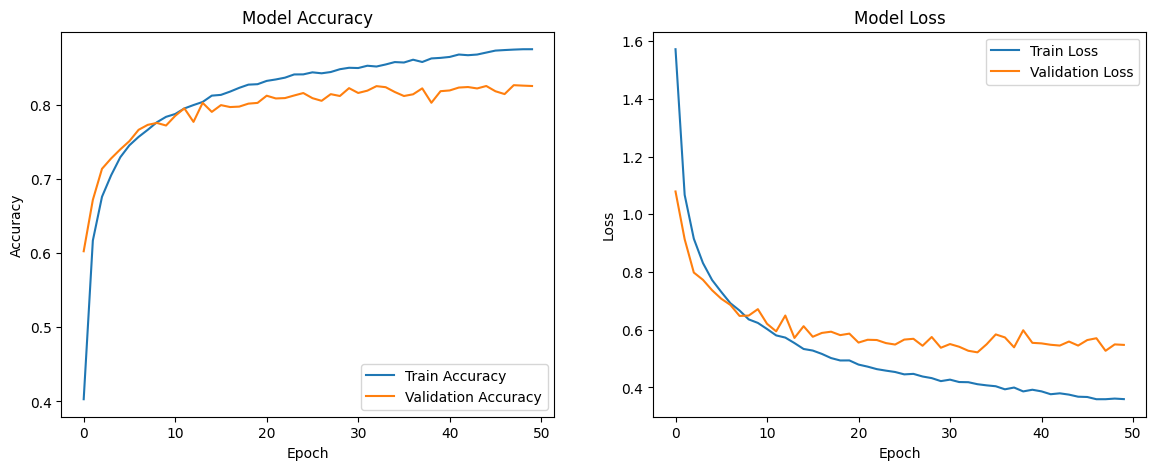

In [177]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

In [178]:
pruned_target_model_by_feature_map_dct.save('pruned_target_by_feature_map_cdct_flop40.h5')

# flops 30%

In [ ]:
keep_filt_conv3_by_filt_norm = filter_to_keep(properties(model, 'conv3', 'filter_norm'), 50)
keep_filt_conv4_by_filt_norm = filter_to_keep(properties(model, 'conv4', 'filter_norm'), 50)
keep_filt_conv5_by_filt_norm = filter_to_keep(properties(model, 'conv5', 'filter_norm'), 5)
keep_filt_conv6_by_filt_norm = filter_to_keep(properties(model, 'conv6', 'filter_norm'), 5)
keep_filt_conv7_by_filt_norm = filter_to_keep(properties(model, 'conv7', 'filter_norm'), 5)



In [ ]:
'''pruned_target_model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=X.shape[1:], name='target_conv1'),
        MaxPooling2D((2,2), name='target_pool1'),
        Conv2D(len(keep_filt), (3,3), activation='relu', name='target_conv2'),
        MaxPooling2D((2,2), name='target_pool2'),
        Flatten(name='target_flatten'),
        Dense(len(keep_filt), activation='relu', name='target_fc1'),
        Dense(10, activation='softmax', name='target_output')
        ])'''

pruned_target_model_by_filt_norm = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv3_by_filt_norm), (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv3'),
        Conv2D(len(keep_filt_conv4_by_filt_norm), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv5_by_filt_norm), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv5'),
        Conv2D(len(keep_filt_conv6_by_filt_norm), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv7_by_filt_norm), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(len(keep_filt_conv7_by_filt_norm), activation='relu',kernel_initializer='he_normal', name='fc1'),
        Dense(64, activation='relu',kernel_initializer='he_normal', name='fc2'),
        Dense(10, activation='softmax', name='output')
        ])

In [ ]:
copy_weights_pruned(model, pruned_target_model_by_filt_norm, [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ keep_filt_conv3_by_filt_norm, keep_filt_conv4_by_filt_norm, keep_filt_conv5_by_filt_norm, keep_filt_conv6_by_filt_norm, keep_filt_conv7_by_filt_norm])
pruned_target_model_by_filt_norm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
get_flops(pruned_target_model_by_filt_norm, train_images.shape)


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

2024-10-31 15:33:03.760123: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-31 15:33:03.760227: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-10-31 15:33:03.760279: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-10-31 15:33:03.760499: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-31 15:33:03.760599: I external/local_xla/xla/stream_executor/cuda/cuda_e

2421403800000

In [ ]:
pruned_target_model_by_filt_norm.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        896       
                                                                 
 conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 dropout_132 (Dropout)       (None, 16, 16, 32)        0         
                                                                 
 conv3 (Conv2D)              (None, 16, 16, 32)        9248      
                                                                 
 conv4 (Conv2D)              (None, 16, 16, 32)        9248      
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 32)        

In [ ]:
pruned_target_model_by_filt_norm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = pruned_target_model_by_filt_norm.fit(train_images, train_labels, epochs=100, batch_size=64, validation_data=(val_images, val_labels))

Epoch 1/100


2024-10-31 15:33:08.286036: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_33/dropout_132/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 7s 7ms/step - loss: 1.5155 - accuracy: 0.4350 - val_loss: 1.0810 - val_accuracy: 0.6105
Epoch 2/100
625/625 [==============================] - 4s 6ms/step - loss: 1.0528 - accuracy: 0.6245 - val_loss: 0.8860 - val_accuracy: 0.6900
Epoch 3/100
625/625 [==============================] - 4s 6ms/step - loss: 0.9096 - accuracy: 0.6789 - val_loss: 0.8181 - val_accuracy: 0.7103
Epoch 4/100
625/625 [==============================] - 4s 6ms/step - loss: 0.8205 - accuracy: 0.7129 - val_loss: 0.8086 - val_accuracy: 0.7139
Epoch 5/100
625/625 [==============================] - 4s 7ms/step - loss: 0.7686 - accuracy: 0.7307 - val_loss: 0.6983 - val_accuracy: 0.7558
Epoch 6/100
625/625 [==============================] - 4s 7ms/step - loss: 0.7120 - accuracy: 0.7502 - val_loss: 0.6622 - val_accuracy: 0.7664
Epoch 7/100
625/625 [==============================] - 4s 7ms/step - loss: 0.6767 - accuracy: 0.7645 - val_loss: 0.6633 - val_accuracy: 0.7691
Epoch 8/100

In [ ]:
test_loss, test_acc = pruned_target_model_by_filt_norm.evaluate(test_images, test_labels, verbose=2)


313/313 - 1s - loss: 0.6372 - accuracy: 0.8211 - 510ms/epoch - 2ms/step


In [ ]:
train_loss, train_acc = pruned_target_model_by_filt_norm.evaluate(train_images, train_labels, verbose=2)


1250/1250 - 2s - loss: 0.0704 - accuracy: 0.9833 - 2s/epoch - 1ms/step


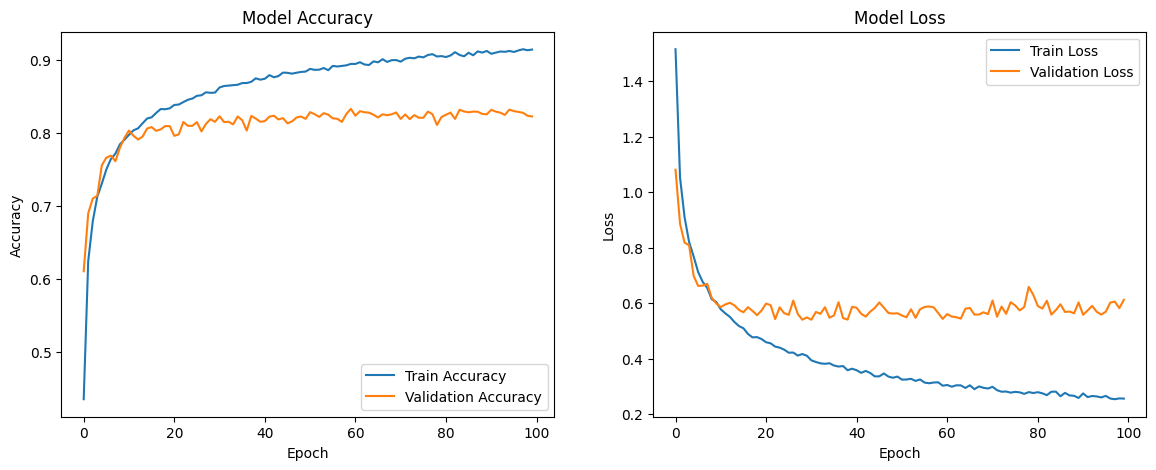

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()


In [ ]:
pruned_target_model_by_filt_norm.save('pruned_target_by_filt_norm_flop30.h5')

In [ ]:
keep_filt_conv3_by_filt_correlation = filter_to_keep(properties(model, 'conv3', 'filter_correlation'), 50)
keep_filt_conv4_by_filt_correlation = filter_to_keep(properties(model, 'conv4', 'filter_correlation'), 50)
keep_filt_conv5_by_filt_correlation = filter_to_keep(properties(model, 'conv5', 'filter_correlation'), 5)
keep_filt_conv6_by_filt_correlation = filter_to_keep(properties(model, 'conv6', 'filter_correlation'), 5)
keep_filt_conv7_by_filt_correlation = filter_to_keep(properties(model, 'conv7', 'filter_correlation'), 5)


In [ ]:
pruned_target_model_by_filt_correlation = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv3_by_filt_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv3'),
        Conv2D(len(keep_filt_conv4_by_filt_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv5_by_filt_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv5'),
        Conv2D(len(keep_filt_conv6_by_filt_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv7_by_filt_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(len(keep_filt_conv7_by_filt_correlation), activation='relu',kernel_initializer='he_normal', name='fc1'),
        Dense(64, activation='relu',kernel_initializer='he_normal', name='fc2'),
        Dense(10, activation='softmax', name='output')
        ])

In [ ]:
copy_weights_pruned(model, pruned_target_model_by_filt_correlation, [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ keep_filt_conv3_by_filt_correlation, keep_filt_conv4_by_filt_correlation, keep_filt_conv5_by_filt_correlation, keep_filt_conv6_by_filt_correlation, keep_filt_conv7_by_filt_correlation])

In [ ]:
pruned_target_model_by_filt_correlation.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = pruned_target_model_by_filt_correlation.fit(train_images, train_labels, epochs=100, batch_size=64, validation_data=(val_images, val_labels))

Epoch 1/100


2024-10-31 15:40:27.256796: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_34/dropout_136/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 7s 8ms/step - loss: 1.5486 - accuracy: 0.4172 - val_loss: 1.2071 - val_accuracy: 0.5686
Epoch 2/100
625/625 [==============================] - 4s 6ms/step - loss: 1.0693 - accuracy: 0.6175 - val_loss: 0.9965 - val_accuracy: 0.6538
Epoch 3/100
625/625 [==============================] - 5s 7ms/step - loss: 0.9157 - accuracy: 0.6772 - val_loss: 0.8112 - val_accuracy: 0.7154
Epoch 4/100
625/625 [==============================] - 4s 7ms/step - loss: 0.8223 - accuracy: 0.7125 - val_loss: 0.7467 - val_accuracy: 0.7378
Epoch 5/100
625/625 [==============================] - 4s 7ms/step - loss: 0.7594 - accuracy: 0.7328 - val_loss: 0.7059 - val_accuracy: 0.7531
Epoch 6/100
625/625 [==============================] - 4s 7ms/step - loss: 0.7165 - accuracy: 0.7503 - val_loss: 0.6584 - val_accuracy: 0.7728
Epoch 7/100
625/625 [==============================] - 4s 7ms/step - loss: 0.6759 - accuracy: 0.7642 - val_loss: 0.6640 - val_accuracy: 0.7714
Epoch 8/100

In [ ]:
test_loss, test_acc = pruned_target_model_by_filt_correlation.evaluate(test_images, test_labels, verbose=2)


313/313 - 0s - loss: 0.6089 - accuracy: 0.8251 - 491ms/epoch - 2ms/step


In [ ]:
train_loss, train_acc = pruned_target_model_by_filt_correlation.evaluate(train_images, train_labels, verbose=2)


1250/1250 - 2s - loss: 0.0616 - accuracy: 0.9868 - 2s/epoch - 2ms/step


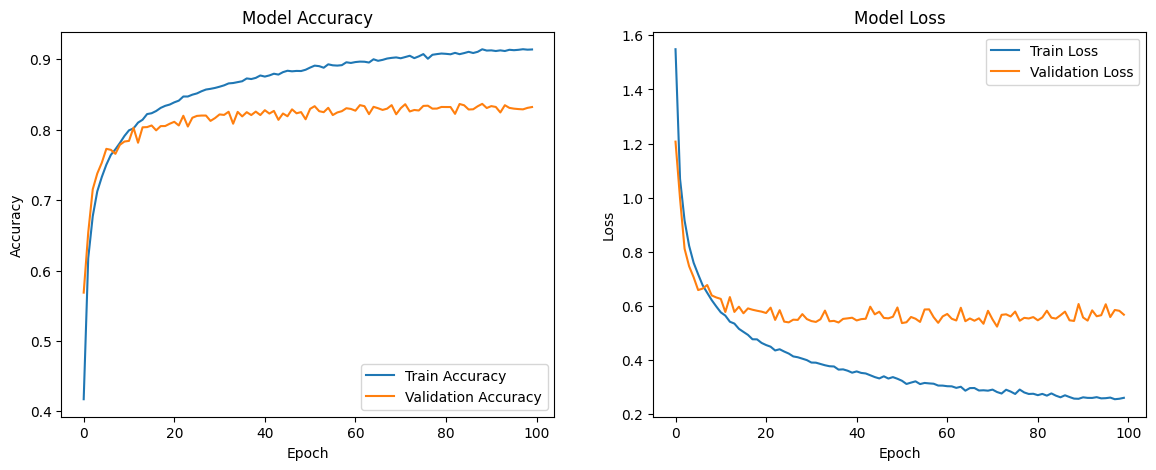

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

In [ ]:
pruned_target_model_by_filt_correlation.save('pruned_target_by_filt_correlation_flop30.h5')

In [ ]:
keep_filt_conv3_by_feature_map_correlation = filter_to_keep(properties(model, 'conv3', 'feature_map_correlation'), 50)
keep_filt_conv4_by_feature_map_correlation = filter_to_keep(properties(model, 'conv4', 'feature_map_correlation'), 50)
keep_filt_conv5_by_feature_map_correlation = filter_to_keep(properties(model, 'conv5', 'feature_map_correlation'), 5)
keep_filt_conv6_by_feature_map_correlation = filter_to_keep(properties(model, 'conv6', 'feature_map_correlation'), 5)
keep_filt_conv7_by_feature_map_correlation = filter_to_keep(properties(model, 'conv7', 'feature_map_correlation'), 5)

32/32 [==============================] - 0s 998us/step


In [ ]:
pruned_target_model_by_feature_map_correlation = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv3_by_feature_map_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv3'),
        Conv2D(len(keep_filt_conv4_by_feature_map_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv5_by_feature_map_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv5'),
        Conv2D(len(keep_filt_conv6_by_feature_map_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv7_by_feature_map_correlation), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(len(keep_filt_conv7_by_feature_map_correlation), activation='relu',kernel_initializer='he_normal', name='fc1'),
        Dense(64, activation='relu',kernel_initializer='he_normal', name='fc2'),
        Dense(10, activation='softmax', name='output')
        ])

In [ ]:
copy_weights_pruned(model, pruned_target_model_by_feature_map_correlation, [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ keep_filt_conv3_by_feature_map_correlation, keep_filt_conv4_by_feature_map_correlation, keep_filt_conv5_by_feature_map_correlation, keep_filt_conv6_by_feature_map_correlation, keep_filt_conv7_by_feature_map_correlation])

In [ ]:
pruned_target_model_by_feature_map_correlation.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = pruned_target_model_by_feature_map_correlation.fit(train_images, train_labels, epochs=100, batch_size=64, validation_data=(val_images, val_labels))

Epoch 1/100


2024-10-31 15:47:26.972073: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_35/dropout_140/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 6s 7ms/step - loss: 1.5443 - accuracy: 0.4240 - val_loss: 1.2627 - val_accuracy: 0.5532
Epoch 2/100
625/625 [==============================] - 4s 6ms/step - loss: 1.0654 - accuracy: 0.6220 - val_loss: 0.8805 - val_accuracy: 0.6894
Epoch 3/100
625/625 [==============================] - 4s 6ms/step - loss: 0.9090 - accuracy: 0.6814 - val_loss: 0.8539 - val_accuracy: 0.6949
Epoch 4/100
625/625 [==============================] - 4s 6ms/step - loss: 0.8206 - accuracy: 0.7127 - val_loss: 0.7083 - val_accuracy: 0.7516
Epoch 5/100
625/625 [==============================] - 4s 6ms/step - loss: 0.7682 - accuracy: 0.7302 - val_loss: 0.7377 - val_accuracy: 0.7366
Epoch 6/100
625/625 [==============================] - 4s 6ms/step - loss: 0.7092 - accuracy: 0.7517 - val_loss: 0.6764 - val_accuracy: 0.7622
Epoch 7/100
625/625 [==============================] - 4s 6ms/step - loss: 0.6802 - accuracy: 0.7616 - val_loss: 0.6759 - val_accuracy: 0.7662
Epoch 8/100

In [ ]:
test_loss, test_acc = pruned_target_model_by_feature_map_correlation.evaluate(test_images, test_labels, verbose=2)


313/313 - 0s - loss: 0.6015 - accuracy: 0.8271 - 491ms/epoch - 2ms/step


In [ ]:
train_loss, train_acc = pruned_target_model_by_feature_map_correlation.evaluate(train_images, train_labels, verbose=2)


1250/1250 - 2s - loss: 0.0689 - accuracy: 0.9849 - 2s/epoch - 2ms/step


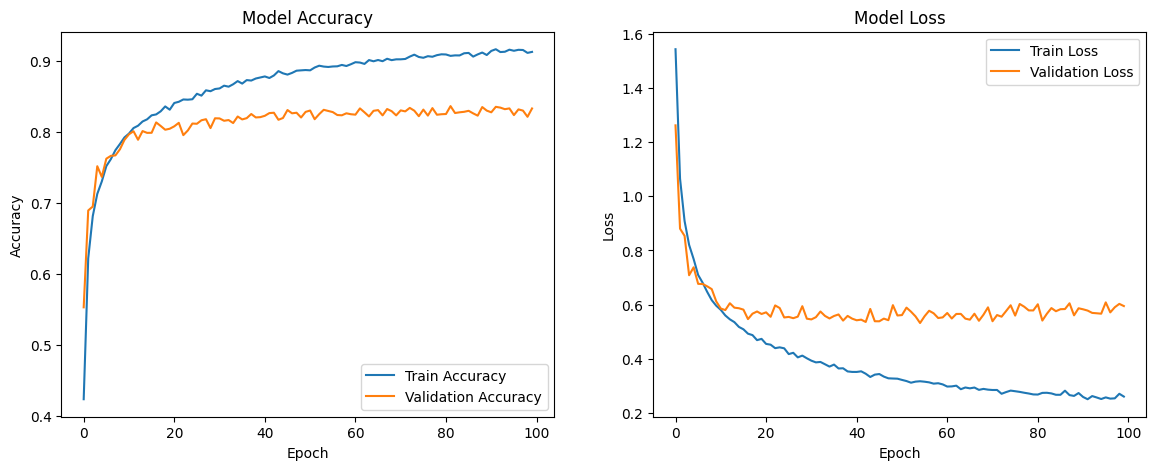

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

In [ ]:
pruned_target_model_by_feature_map_correlation.save('pruned_target_by_feature_map_correlation_flop30.h5')

In [ ]:
keep_filt_conv3_by_feature_map_dct = filter_to_keep(properties(model, 'conv3', 'feature_map_dct'), 50)
keep_filt_conv4_by_feature_map_dct = filter_to_keep(properties(model, 'conv4', 'feature_map_dct'), 50)
keep_filt_conv5_by_feature_map_dct = filter_to_keep(properties(model, 'conv5', 'feature_map_dct'), 5)
keep_filt_conv6_by_feature_map_dct = filter_to_keep(properties(model, 'conv6', 'feature_map_dct'), 5)
keep_filt_conv7_by_feature_map_dct = filter_to_keep(properties(model, 'conv7', 'feature_map_dct'), 5)

32/32 [==============================] - 0s 982us/step


In [ ]:
pruned_target_model_by_feature_map_dct = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv3_by_feature_map_dct), (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv3'),
        Conv2D(len(keep_filt_conv4_by_feature_map_dct), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv5_by_feature_map_dct), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv5'),
        Conv2D(len(keep_filt_conv6_by_feature_map_dct), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(len(keep_filt_conv7_by_feature_map_dct), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(len(keep_filt_conv7_by_feature_map_dct), activation='relu',kernel_initializer='he_normal', name='fc1'),
        Dense(64, activation='relu',kernel_initializer='he_normal', name='fc2'),
        Dense(10, activation='softmax', name='output')
        ])

In [ ]:
copy_weights_pruned(model, pruned_target_model_by_feature_map_dct, [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'], [ keep_filt_conv3_by_feature_map_dct, keep_filt_conv4_by_feature_map_dct, keep_filt_conv5_by_feature_map_dct, keep_filt_conv6_by_feature_map_dct, keep_filt_conv7_by_feature_map_dct])

In [ ]:
pruned_target_model_by_feature_map_dct.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = pruned_target_model_by_feature_map_dct.fit(train_images, train_labels, epochs=100, batch_size=64, validation_data=(val_images, val_labels))

Epoch 1/100


2024-10-31 15:55:53.134977: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_36/dropout_144/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 6s 7ms/step - loss: 1.5734 - accuracy: 0.4158 - val_loss: 1.1594 - val_accuracy: 0.5812
Epoch 2/100
625/625 [==============================] - 4s 6ms/step - loss: 1.0685 - accuracy: 0.6177 - val_loss: 0.9664 - val_accuracy: 0.6588
Epoch 3/100
625/625 [==============================] - 4s 6ms/step - loss: 0.9126 - accuracy: 0.6794 - val_loss: 0.8108 - val_accuracy: 0.7098
Epoch 4/100
625/625 [==============================] - 4s 7ms/step - loss: 0.8184 - accuracy: 0.7136 - val_loss: 0.7237 - val_accuracy: 0.7449
Epoch 5/100
625/625 [==============================] - 4s 7ms/step - loss: 0.7511 - accuracy: 0.7375 - val_loss: 0.7039 - val_accuracy: 0.7524
Epoch 6/100
625/625 [==============================] - 4s 6ms/step - loss: 0.7105 - accuracy: 0.7515 - val_loss: 0.6623 - val_accuracy: 0.7661
Epoch 7/100
625/625 [==============================] - 4s 6ms/step - loss: 0.6734 - accuracy: 0.7633 - val_loss: 0.6229 - val_accuracy: 0.7845
Epoch 8/100

In [ ]:
test_loss, test_acc = pruned_target_model_by_feature_map_dct.evaluate(test_images, test_labels, verbose=2)


313/313 - 0s - loss: 0.5951 - accuracy: 0.8311 - 480ms/epoch - 2ms/step


In [ ]:
train_loss, train_acc = pruned_target_model_by_feature_map_dct.evaluate(train_images, train_labels, verbose=2)


1250/1250 - 2s - loss: 0.0472 - accuracy: 0.9901 - 2s/epoch - 2ms/step


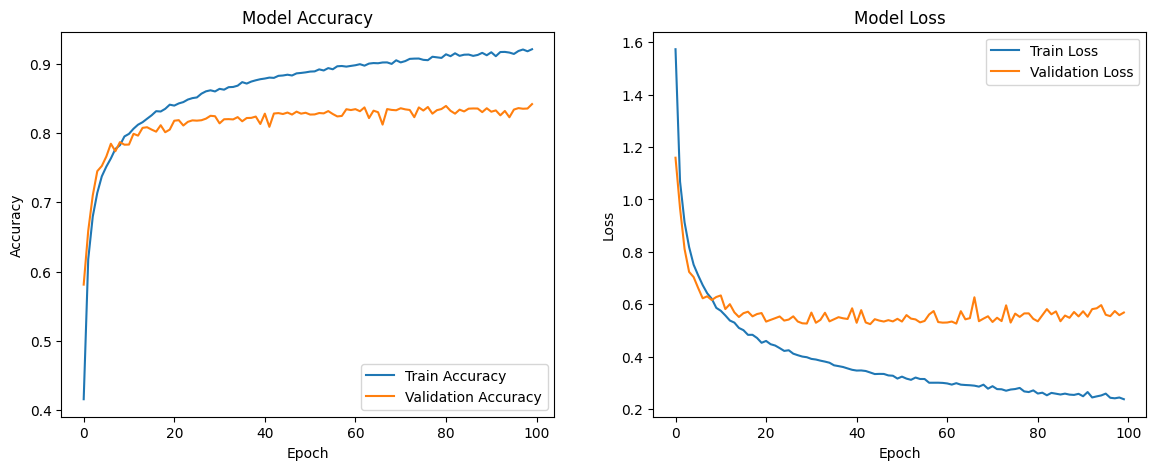

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

In [ ]:
pruned_target_model_by_feature_map_dct.save('pruned_target_by_feature_map_correlation_flop30.h5')

/home/am/Documents/VirtualEnv/tensorflow-gpu/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [179]:
x = [0.4, 0.5, 0.6, 0.7]
train_filt_norm = [0.95, 0.92, 0.898, 0.766]
train_filt_uniqueness = [0.954, 0.929, 0.885, 0.774]
train_hrank = [0.948, 0.938, 0.892, 0.770]
train_dct = [0.952, 0.930, 0.879, 0.782]

In [182]:
test_filt_norm = [0.813, 0.817, 0.808, 0.727]
test_filt_uniqueness = [0.819, 0.818, 0.797, 0.727]
test_hrank = [0.817, 0.814, 0.804, 0.725]
test_dct = [0.824, 0.815, 0.798, 0.738]

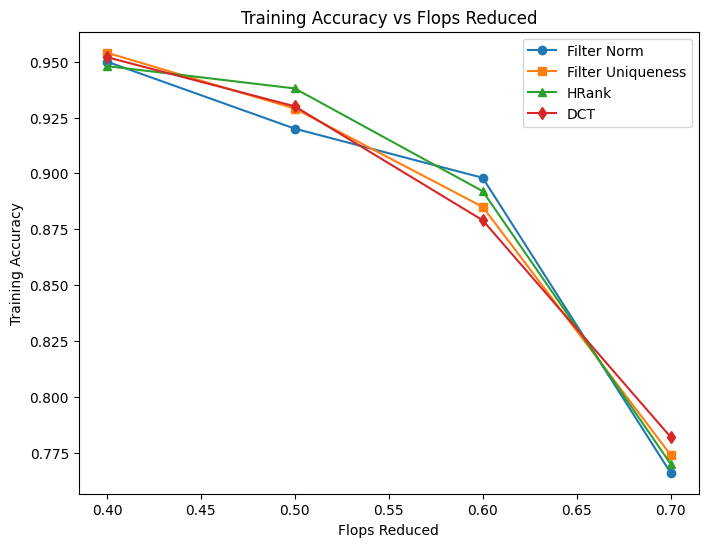

In [181]:
plt.figure(figsize=(8, 6))
plt.plot(x, train_filt_norm, marker='o', label='Filter Norm')
plt.plot(x, train_filt_uniqueness, marker='s', label='Filter Uniqueness')
plt.plot(x, train_hrank, marker='^', label='HRank')
plt.plot(x, train_dct, marker='d', label='DCT')

# Adding labels and title
plt.xlabel("Flops Reduced")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy vs Flops Reduced")
plt.legend()

# Display the plot
plt.show()

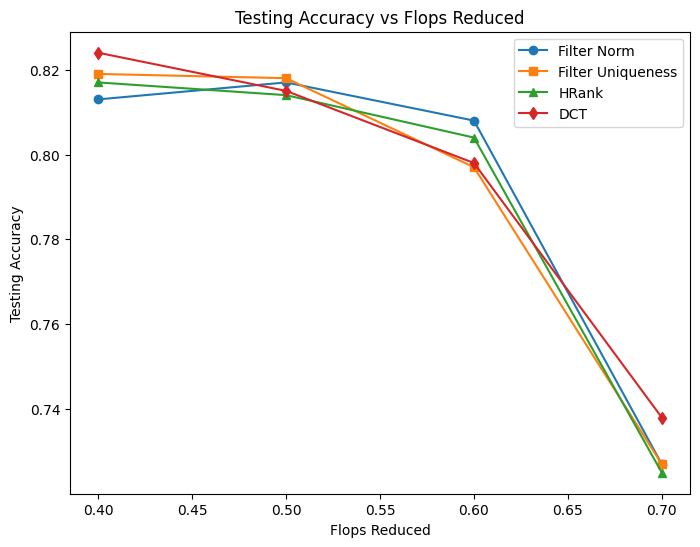

In [183]:
plt.figure(figsize=(8, 6))
plt.plot(x, test_filt_norm, marker='o', label='Filter Norm')
plt.plot(x, test_filt_uniqueness, marker='s', label='Filter Uniqueness')
plt.plot(x, test_hrank, marker='^', label='HRank')
plt.plot(x, test_dct, marker='d', label='DCT')

# Adding labels and title
plt.xlabel("Flops Reduced")
plt.ylabel("Testing Accuracy")
plt.title("Testing Accuracy vs Flops Reduced")
plt.legend()

# Display the plot
plt.show()


In [187]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [186]:
!pip install pydot


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
